# Networks Construction & Topology Analysis

In [4]:
from __future__ import division
import logging
import logging.config
import sys, csv, time, requests, statsmodels, math
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint, adfuller, grangercausalitytests
import statsmodels.api as sm
from scipy import stats
import scipy.special
from scipy.stats import describe
from scipy.linalg import circulant
from contextlib import contextmanager
from datetime import datetime, timedelta
from dateutil.parser import parse
import collections
import random
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
import pylab
import powerlaw
import networkx as nx
from networkx.algorithms import community
import pandas as pd
import numpy as np
from core import SendEmail, ROOTPATH, sri_SP500_log_return
from preprocess_stocks import lst_tickers_stp, LENTCKR, LENTRGL, df_codes_and_title, DICT_STP, getIndustryCodeByStockCode

In [5]:
data_dir = ROOTPATH + r'/Codes'

In [6]:
# function for generating PGD
def genPureDedirectedGraph(theta_1, theta_2, mat_1, mat_2):
    G = nx.DiGraph()
    G.add_nodes_from(lst_tickers_stp)
    for i in lst_tickers_stp:
        #print(i, end=' ')
        matidx_i = EIO_industry_BEA_code_list.index(
            df_codes_and_title.loc[i, 'BEA'])
        for j in lst_tickers_stp:
            if i != j:
                matidx_j = EIO_industry_BEA_code_list.index(
                    df_codes_and_title.loc[j, 'BEA'])
                a = mat_1[matidx_i, matidx_j]
                b = mat_2[matidx_i, matidx_j]
                if a > 0.0 and a > theta_1:
                    G.add_edge(i, j)
                if b > 0.0 and b > theta_2:
                    G.add_edge(j, i)
    return G

def genWDGraphFromPureDirectedGraph(PGD, return_list, threshold=-1):
    G = nx.DiGraph()
    G.add_nodes_from(lst_tickers_stp)
    for n, nbrs in PGD.adj.items():
        S1 = return_list[n]
        for nbr, eattr in nbrs.items():
            S2 = return_list[nbr]
            corr = S1.corr(S2)
            if corr >= threshold: G.add_edge(n, nbr, corr=corr)
    return G

# function for generating PCGD
# generate partial correlation directed graph
def genPartCorrGraph(UGD):
    G = nx.DiGraph()
    G.add_nodes_from(lst_tickers_stp)
    for n, nbrs in UGD.adj.items():
        for nbr, eattr in nbrs.items():
            G.add_edge(n, nbr, weight=eattr['corr'])
    return G

# function for generating ECGU
# generate entire correlation undirected graph
def genEntCorrGraph():
    G = nx.Graph()
    G.add_nodes_from(lst_tickers_stp)
    for i in range(LENTCKR):
        S1 = df_stock_abr[lst_tickers_stp[i]]
        for j in range(i+1, LENTCKR):
            S2 = df_stock_abr[lst_tickers_stp[j]]
            G.add_edge(n, nbr, weight=S1.corr(S2))
    return G

def rmvEdgeAttrOfGraph(WG):
    G = WG.copy()
    for n, nbrs in G.adj.items():
        for nbr, eattr in nbrs.items():
            if 'corr' in eattr: del eattr['corr']
    return G

def rmvIndepNodesFromGraph(WholeG):
    G = WholeG.copy()
    for n in WholeG.nodes():
        if WholeG.degree(n) == 0: G.remove_node(n)
    return G

In [7]:
def _distance_matrix(L):
    Dmax = L//2

    D = list(range(Dmax+1))
    D += D[-2+(L%2):0:-1]

    return circulant(D)/Dmax

def _pd(d, p0, beta):
    return beta*p0 + (d <= p0)*(1-beta)

def watts_strogatz(L, p0, beta, directed=False, rngseed=1):
    """
    Watts-Strogatz model of a small-world network

    This generates the full adjacency matrix, which is not a good way to store
    things if the network is sparse.

    Parameters
    ----------
    L        : int
               Number of nodes.
 
    p0       : float
               Edge density. If K is the average degree then p0 = K/(L-1).
               For directed networks "degree" means out- or in-degree.
 
    beta     : float
               "Rewiring probability."
 
    directed : bool
               Whether the network is directed or undirected.
 
    rngseed  : int
               Seed for the random number generator.
 
    Returns
    -------
    A        : (L, L) array
               Adjacency matrix of a WS (potentially) small-world network.
 
    """
    rng = np.random.RandomState(rngseed)

    d = _distance_matrix(L)
    p = _pd(d, p0, beta)

    if directed:
        A = 1*(rng.random_sample(p.shape) < p)
        np.fill_diagonal(A, 0)
    else:
        upper = np.triu_indices(L, 1)
 
        A          = np.zeros_like(p, dtype=int)
        A[upper]   = 1*(rng.rand(len(upper[0])) < p[upper])
        A.T[upper] = A[upper]

    return A

## 1. Basic information

In [8]:
print('Number of stocks: %s' % LENTCKR)
print('Number of named industries: %s' % len(np.unique(df_codes_and_title['Title'])))
print('Number of BEA industries: %s' % len(np.unique(df_codes_and_title['BEA'])))
print('Number of NAICS industries: %s' % len(np.unique(df_codes_and_title['NAICS'])))

Number of stocks: 1418
Number of named industries: 55
Number of BEA industries: 56
Number of NAICS industries: 199


##### Count of stocks by industry category

In [9]:
dct_title_amt = dict(df_codes_and_title['Title'].value_counts())
dct_BEA_amt = dict(df_codes_and_title['BEA'].value_counts())

In [10]:
def genEIODirectMatrix(directType, tradeoff = True, to_log = True):
    global dct_title_amt
    global EIO_industry_title_list
    industry_list = EIO_industry_title_list
    EIO_direct_matrix = np.matrix(
        np.zeros(
            (len(industry_list),
             len(industry_list)),
            dtype=np.float64))
    if directType is 'requirements':
        for i in range(len(industry_list)):
            for j in range(len(industry_list)):
                if EIO_matrix[i, j] > 0:
                    m = np.float64(EIO_matrix[i, j]) / EIO_matrix[-1, j]
                    if tradeoff and industry_list[i] in dct_title_amt:
                        m /= dct_title_amt[industry_list[i]]
                    EIO_direct_matrix[i, j] = logarise(m) if to_log else m
    elif directType is 'demands':
        for i in range(len(industry_list)):
            for j in range(len(industry_list)):
                if EIO_matrix[i, j] > 0:
                    m = np.float64(EIO_matrix[i, j]) / EIO_matrix[i, -1]
                    if tradeoff and industry_list[j] in dct_title_amt:
                        m /= dct_title_amt[industry_list[j]]
                    EIO_direct_matrix[i, j] = logarise(m) if to_log else m
    else: return None
    return EIO_direct_matrix

def getAllMatrixContent(mat):
    arr = []
    for m in mat:
        arr = np.append(arr, np.array(m)[0])
    return arr

def getNonzeroMatrixContent(mat):
    arr = []
    for m in mat:
        ar_m = np.array(m)[0]
        ar_m = ar_m[ar_m!=0]
        arr = np.append(arr, ar_m)
    return arr

def genEdgeDensity(lst, bins=100):
    theta_thresholds = np.linspace(np.floor(min(lst)*10.0)/10.0, np.ceil(max(lst)*10.0)/10.0, bins)
    edge_densities = []
    n = 0
    LENLST_FLOAT = np.float(len(lst))
    for theta in theta_thresholds:
        n += 1
        #print(n, end=' ')
        edge_densities.append(sum(corr >= theta for corr in lst)/LENLST_FLOAT)
    return theta_thresholds, edge_densities

def logarise(n): return 0.0 if n == 0 else -1.0/np.log10(n)

def combineThresholds(thresholds_1, thresholds_2, mat_1, mat_2):
    LENMAT = mat_1.shape[0]
    df = pd.DataFrame(
        index=range(len(thresholds_1)*len(thresholds_2)),
        columns=['theta_DR', 'theta_DD', 'no_directions'])
    idx = 0
    print(len(thresholds_1), end='')
    for t1 in thresholds_1:
        print('.', end='')
        exceeded = False
        for t2 in thresholds_2:
            cnt = 0
            if not exceeded:
                for i in range(LENMAT):
                    for j in range(LENMAT):
                        a = mat_1[i, j]
                        b = mat_2[i, j]
                        if (a > 0.0 and a > t1) or (b > 0.0 and b > t2):
                            cnt += 1
                if cnt == 0: exceeded = True
            df.iloc[idx,:] = [t1, t2, cnt]
            idx += 1
    return df

def combineThresholdsOfEIOAndCorrForAmtOfEdges(thresholds_eio, thresholds_corr, FG):
    global lst_tickers_stp
    df = pd.DataFrame(
        index=range(len(thresholds_eio)*len(thresholds_corr)),
        columns=['theta_EIO', 'theta_corr', 'no_edges'])
    idx = 0
    numrow = 0
    for t1 in thresholds_eio:
        print('[%s]' % numrow)
        exceeded = False
        for t2 in thresholds_corr:
            cnt = 0
            if not exceeded:
                for n, nbrs in FG.adj.items():
                    for nbr, eattr in nbrs.items():
                        if ('direct_requirement' in eattr and eattr['direct_requirement'] > t1) or ('direct_demand' in eattr and (eattr['direct_demand'] > t1)):
                            if eattr['corr'] > t2: cnt += 1
                if cnt == 0: exceeded = True
            print(cnt, end=' ')
            df.iloc[idx,:] = [t1, t2, cnt]
            idx += 1
        numrow += 1
    return df

def combineThresholdsOfEIOAndCorrForIsWeaklyConnected(thresholds_eio, thresholds_corr, FG):
    global lst_tickers_stp
    df = pd.DataFrame(
        index=range(len(thresholds_eio)*len(thresholds_corr)),
        columns=['EIO', 'corr', 'is_weakly_connected'])
    idx = 0
    for t1 in thresholds_eio:
        for t2 in thresholds_corr:
            G = nx.DiGraph()
            G.add_nodes_from(lst_tickers_stp)
            for n, nbrs in FG.adj.items():
                for nbr, eattr in nbrs.items():
                    if ('direct_requirement' in eattr and eattr['direct_requirement'] > t1) or ('direct_demand' in eattr and (eattr['direct_demand'] > t1)):
                        if eattr['corr'] > t2: G.add_edge(n, nbr)
            G = rmvIndepNodesFromGraph(G)
            print(G.number_of_nodes(), end=' ')
            if G.number_of_nodes() > 0:
                is_weakly_c = nx.is_weakly_connected(G)  
                print(is_weakly_c, end=' ')
                df.iloc[idx,:] = [t1, t2, is_weakly_c]
            else:
                print('Nill', end=' ')
                df.iloc[idx,:] = [t1, t2, False]
            idx += 1
    return df

In [11]:
def continueCombineThresholdsOfEIOAndCorrForIsWeaklyConnected(thresholds_eio, thresholds_corr, FG, start_point):
    global df
    i = 0
    idx = start_point
    cnt = 0
    for t1 in thresholds_eio:
        print('[%s]' % cnt)
        for t2 in thresholds_corr:
            if i < start_point:
                i += 1
                continue
            G = nx.DiGraph()
            G.add_nodes_from(lst_tickers_stp)
            for n, nbrs in FG.adj.items():
                for nbr, eattr in nbrs.items():
                    if ('direct_requirement' in eattr and eattr['direct_requirement'] > t1) or ('direct_demand' in eattr and (eattr['direct_demand'] > t1)):
                        if eattr['corr'] > t2: G.add_edge(n, nbr)
            G = rmvIndepNodesFromGraph(G)
            print(G.number_of_nodes(), end=' ')
            if G.number_of_nodes() > 0:
                is_weakly_c = nx.is_weakly_connected(G)  
                print(is_weakly_c, end=' ')
                df.iloc[idx,:] = [t1, t2, is_weakly_c]
            else:
                print('Nill', end=' ')
                df.iloc[idx,:] = [t1, t2, False]
            idx += 1
        cnt += 1

#### Read EIO & stock return files

In [12]:
FILE_EIO_2016 = ROOTPATH + '/Source/lxl/EIO_2016.csv'
EIO_matrix = np.matrix(np.genfromtxt(open(FILE_EIO_2016, 'rb'), delimiter=',', skip_header=2))
EIO_industry_BEA_code_list = list(pd.read_csv(FILE_EIO_2016, nrows=0).columns)[:-2]
EIO_industry_title_list = list(pd.read_csv(FILE_EIO_2016, skiprows=1).columns)[:-2]
FILE_STOCK_ABR = ROOTPATH + r'/Source/DF_STOCK_ABR.csv'
df_stock_abr = pd.read_csv(FILE_STOCK_ABR).set_index('Date')
df_stock_normal_return = pd.DataFrame(index=df_stock_abr.index, columns=df_stock_abr.columns)
for i in DICT_STP: df_stock_normal_return[i] = DICT_STP[i]['log_return']

## 2. Construct two normalised EIO matrices
**Direct requirements matrix** contains direct coefficients $a_{ij}=z_{ij}/X_j$,
<br>
**Direct demands matrix** contains direct coefficients $a_{ij}=z_{ij}/X'_i$
<br>
<br>
**X** is the total industrial input that lies in the last row of the EIO matrix **Z**,
<br>
while **X'** is the total throughput of the economy that lies in the last column of the EIO matrix **Z**

In [13]:
EIO_direct_requirements_matrix = genEIODirectMatrix('requirements', tradeoff=True, to_log=True)
EIO_direct_demands_matrix = genEIODirectMatrix('demands', tradeoff=True, to_log=True)

In [14]:
print('Max in EIO_direct_requirements_matrix: %s' % max([max(np.array(m)[0]) for m in EIO_direct_requirements_matrix]))
print('Max in EIO_direct_demands_matrix: %s' % max([max(np.array(m)[0]) for m in EIO_direct_demands_matrix]))

Max in EIO_direct_requirements_matrix: 1.4758950452420967
Max in EIO_direct_demands_matrix: 2.4431978409640456


## 3. Pre-processing for Construction of Stock Networks

#### Pre-process normalised EIO matrices

In [15]:
ar_all_DR_Mat = getAllMatrixContent(EIO_direct_requirements_matrix)
ar_all_DD_Mat = getAllMatrixContent(EIO_direct_demands_matrix)

ar_all_DR_trans = [i for i in ar_all_DR_Mat]
ar_all_DD_trans = [i for i in ar_all_DD_Mat]

theta_thresholds_DR_all, edge_densities_DR_all = genEdgeDensity(ar_all_DR_trans, 100)
theta_thresholds_DD_all, edge_densities_DD_all = genEdgeDensity(ar_all_DD_trans, 100)

ar_nonzero_DR_Mat = getNonzeroMatrixContent(EIO_direct_requirements_matrix)
ar_nonzero_DD_Mat = getNonzeroMatrixContent(EIO_direct_demands_matrix)

ar_nonzero_DR_trans = [i for i in ar_nonzero_DR_Mat]
ar_nonzero_DD_trans = [i for i in ar_nonzero_DD_Mat]

theta_thresholds_DR, edge_densities_DR = genEdgeDensity(ar_nonzero_DR_trans, 100)
theta_thresholds_DD, edge_densities_DD = genEdgeDensity(ar_nonzero_DD_trans, 100)

[Figures] show the relationship between transaction density and thresholds of direct requirement and direct demand respectively. As we can see, two graphs are very similar, so we set $\theta_1=\theta_2$.

In [16]:
b1 = np.append(1.0, edge_densities_DR_all)
b1[1] = b1[2]
b2 = np.append(0, theta_thresholds_DR_all)

In [17]:
theta_thresholds_DR_all

array([0.        , 0.01515152, 0.03030303, 0.04545455, 0.06060606,
       0.07575758, 0.09090909, 0.10606061, 0.12121212, 0.13636364,
       0.15151515, 0.16666667, 0.18181818, 0.1969697 , 0.21212121,
       0.22727273, 0.24242424, 0.25757576, 0.27272727, 0.28787879,
       0.3030303 , 0.31818182, 0.33333333, 0.34848485, 0.36363636,
       0.37878788, 0.39393939, 0.40909091, 0.42424242, 0.43939394,
       0.45454545, 0.46969697, 0.48484848, 0.5       , 0.51515152,
       0.53030303, 0.54545455, 0.56060606, 0.57575758, 0.59090909,
       0.60606061, 0.62121212, 0.63636364, 0.65151515, 0.66666667,
       0.68181818, 0.6969697 , 0.71212121, 0.72727273, 0.74242424,
       0.75757576, 0.77272727, 0.78787879, 0.8030303 , 0.81818182,
       0.83333333, 0.84848485, 0.86363636, 0.87878788, 0.89393939,
       0.90909091, 0.92424242, 0.93939394, 0.95454545, 0.96969697,
       0.98484848, 1.        , 1.01515152, 1.03030303, 1.04545455,
       1.06060606, 1.07575758, 1.09090909, 1.10606061, 1.12121

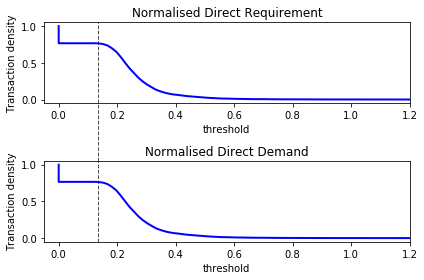

In [18]:
x_dashline = 0.136
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.set_xlabel('threshold')
ax.set_ylabel('Transaction density')
ax.set_xlim(left=-0.05, right=1.2)
ax.set_title('Normalised Direct Requirement', fontsize='large')
dashed_line = Line2D([x_dashline, x_dashline], [-1.05, 1.05], linestyle = '--', linewidth = 1, color = [0.3,0.3,0.3], zorder = 1, transform = ax.transData)
ax.lines.append(dashed_line)
ax.plot(b2, b1, color='blue', lw=2)
ax = fig.add_subplot(2,1,2)
ax.set_xlabel('threshold')
ax.set_ylabel('Transaction density')
ax.set_title('Normalised Direct Demand', fontsize='large')
dashed_line = Line2D([x_dashline, x_dashline], [-0.05, 1.05], linestyle = '--', linewidth = 1, color = [0.3,0.3,0.3], zorder = 1, transform = ax.transData)
ax.lines.append(dashed_line)
ax.set_xlim(left=-0.05, right=1.2)
ax.plot(b2, b1, color='blue', lw=2)
fig.tight_layout()
#fig.savefig(ROOTPATH + '/Msc/Dissertation/Figures/eio_transaction_density.pdf', bbox_inches='tight')

In [62]:
df_combined_thresholds = combineThresholds(
    theta_thresholds_DR,
    theta_thresholds_DD,
    EIO_direct_requirements_matrix,
    EIO_direct_demands_matrix)

100....................................................................................................

In [63]:
pt = df_combined_thresholds.pivot_table(index='theta_DR', columns='theta_DD', values='no_directions', aggfunc=np.sum)

Text(69,0.5,'theta_DR')

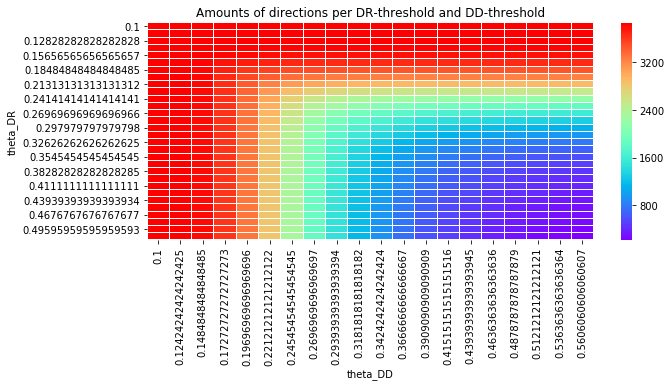

In [172]:
f, ax = plt.subplots(figsize = (10, 4))
#cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
sns.heatmap(pt.iloc[:30,:20], cmap='rainbow', linewidths = 0.05, ax = ax)
ax.set_title('Amounts of directions per DR-threshold and DD-threshold')
ax.set_xlabel('theta_DD')
ax.set_ylabel('theta_DR')

#### Construct a full network

In [19]:
def genFullGraph(stock_return_df):
    global lst_tickers_stp
    global EIO_industry_BEA_code_list
    global EIO_direct_requirements_matrix
    G = nx.DiGraph()
    G.add_nodes_from(lst_tickers_stp)
    for i in lst_tickers_stp:
        #print(i, end=' ')
        matidx_i = EIO_industry_BEA_code_list.index(df_codes_and_title.loc[i, 'BEA'])
        S1 = stock_return_df[i]
        for j in lst_tickers_stp:
            if i != j:
                matidx_j = EIO_industry_BEA_code_list.index(df_codes_and_title.loc[j, 'BEA'])
                if EIO_direct_requirements_matrix[matidx_i, matidx_j] > 0:
                    G.add_edge(i, j, direct_requirement = EIO_direct_requirements_matrix[matidx_i, matidx_j])
                if EIO_direct_demands_matrix[matidx_j, matidx_i] > 0:
                    G.add_edge(i, j, direct_demand = EIO_direct_demands_matrix[matidx_j, matidx_i])
                if G.has_edge(i, j): G.add_edge(i, j, corr=S1.corr(stock_return_df[j]))
    return G

In [15]:
G = nx.read_gml(ROOTPATH + '/Codes/test_com_over_best.gml')

In [27]:
FullG = genFullGraph(df_stock_normal_return)

In [28]:
direct_requirements_CN = []
direct_demands_CN = []
for n, nbrs in FullG.adj.items():
    for nbr, eattr in nbrs.items():
        if 'direct_requirement' in eattr.keys():
            direct_requirements_CN.append(eattr['direct_requirement'])
        if 'direct_demand' in eattr.keys():
            direct_demands_CN.append(eattr['direct_demand'])

#### Pre-process correlation coefficients

In [29]:
corr_coef_CN = []
for n, nbrs in FullG.adj.items():
    for nbr, eattr in nbrs.items():
        corr_coef_CN.append(eattr['corr'])

[Figure] shows the distribution of the correlation coefficients based on the close price data in the year of 2016. It can be seen that this plot has a shape similar to the t-distribution with a mean of 0.265. Most coefficients are at the interval of [-0.1, 0.7], and all of them are larger than -0.6868.

Text(0,0.5,'p(correlation)')

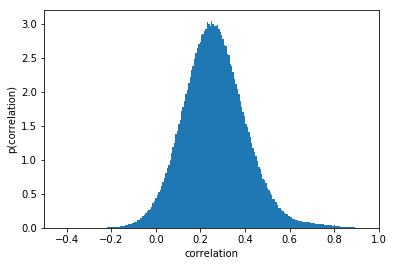

In [30]:
plt.hist(corr_coef_CN, density=1, bins=260, histtype='bar')
plt.axis([-0.5, 1, 0, 3.2])
#axis([xmin,xmax,ymin,ymax])
plt.xlabel('correlation')
plt.ylabel('p(correlation)')
#plt.title('correlation coefficient distribution')
#plt.savefig(ROOTPATH + '/Msc/Dissertation/Figures/correlation_distribution.pdf', bbox_inches='tight')

In [31]:
describe(corr_coef_CN)

DescribeResult(nobs=1937304, minmax=(-0.6868084783629813, 0.9772224744852486), mean=0.26474010281270655, variance=0.0201240778829594, skewness=0.3439511297826952, kurtosis=0.7216782786160216)

In [32]:
corr_mean = np.mean(corr_coef_CN)
corr_std = np.std(corr_coef_CN)
corr_coef_CN_00 = [(i - corr_mean)/corr_std for i in corr_coef_CN]

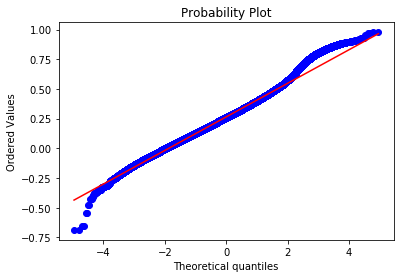

In [33]:
stats.probplot(corr_coef_CN, dist='norm', plot=pylab)
pylab.show()

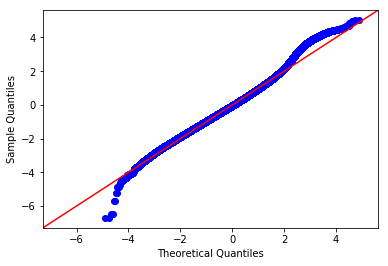

In [35]:
sm.qqplot(np.array(corr_coef_CN_00), line='45',)
pylab.show()

In [36]:
ss.kstest(corr_coef_CN_00, 'norm')

KstestResult(statistic=0.022342235392551646, pvalue=0.0)

In [37]:
%%time
theta_thresholds_corr, edge_densities_corr = genEdgeDensity(corr_coef_CN, 100)

CPU times: user 8min 25s, sys: 961 ms, total: 8min 26s
Wall time: 8min 28s


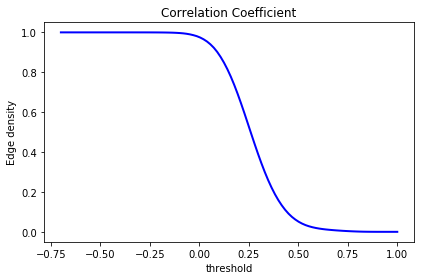

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('threshold')
ax.set_ylabel('Edge density')
ax.set_title('Correlation Coefficient', fontsize='large')
ax.plot(theta_thresholds_corr, edge_densities_corr, color='blue', lw=2)
fig.tight_layout()
#fig.savefig(ROOTPATH + '/Msc/Dissertation/Figures/correlation_edge_density.pdf', bbox_inches='tight')

#### Determine the thresholds of EIO and correaltion networks for contructing stock networks

In [181]:
recalc = False
npzfile_name = data_dir + '/pt_cteac_0719.npz'
pt_cteac = None
if recalc == True:
    df = pd.DataFrame(
        index=range(len(theta_thresholds_DR)*len(theta_thresholds_corr)),
        columns=['EIO', 'corr', 'is_weakly_connected'])
    continueCombineThresholdsOfEIOAndCorrForIsWeaklyConnected(
        theta_thresholds_DR, theta_thresholds_corr, FullG, 0)
    df_cteac = df.copy()
    pt_cteac = df_cteac.pivot_table(
        index = 'EIO', columns='corr',
        values = 'is_weakly_connected', aggfunc=np.sum)
    outfile = open(npzfile_name, 'wb')
    np.savez(outfile, ar_cteac=pt_cteac, col=pt_cteac.columns, ind=pt_cteac.index)
    outfile.close()
else:
    infile = open(npzfile_name, 'rb')
    npzfile = np.load(infile)
    infile.close()
    ar_cteac = npzfile['ar_cteac']
    pt_cteac = pd.DataFrame(ar_cteac)
    pt_cteac.columns = npzfile['col']
    pt_cteac.index = npzfile['ind']

[0]
1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1417 True 1416 True 1415 True 1415 True 1413 True 1411 True 1410 True 1404 True 1399 True 1395 True 1388 True 1373 True 1362 False 1350 False 1336 False 1304 False 1271 False 1211 False 1170 False 1122 False 1066 False 1001 False 942 False 869 False 806 False 747 False 690 False 640 False 600 False 553 False 498 False 455 False 407 False 364 False 316 False 272 False 244 False 198 False 145 False 121 False 87 False 57 False 34 False 17 False 8 False 6 False 4 False 0 Nill 0 Nill [1

1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1418 True 1416 True 1416 True 1416 True 1414 True 1414 True 1414 True 1410 True 1407 True 1400 True 1395 True 1386 True 1377 True 1354 True 1331 True 1302 True 1272 True 1235 False 1199 False 1150 False 1096 False 1037 False 970 False 896 False 827 False 759 False 694 False 616 False 564 False 502 False 449 False 385 False 336 False 306 False 267 False 241 False 211 False 190 False 163 False 150 False 118 False 96 False 76 False 58 False 40 False 29 False 20 False 16 False 11 False 8 False 6 False 6 False 4 False 0 Nill 0 Nill [17]
1418 True 14

741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 741 False 740 False 740 False 740 False 739 False 739 False 739 False 738 False 736 False 735 False 734 False 730 False 722 False 711 False 702 False 681 False 656 False 630 False 601 False 578 False 554 False 518 False 485 False 462 False 428 False 402 False 381 False 357 False 340 False 315 False 296 False 272 False 257 False 225 False 196 False 165 False 138 False 107 False 78 False 61 False 37 False 21 False 12 False 4 False 4 False 4 False 4 False 2 True 2 True 2 True 2 True 2 True 2 True 2 True 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill [33]
503 False 503 False 503 False 503 False 503 False 503 False 503 F

10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 9 False 9 False 9 False 9 False 9 False 8 False 8 False 7 False 7 False 6 False 6 False 4 False 2 True 2 True 2 True 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill [50]
10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 10 False 

0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill [72]
0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0

0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill [94]
0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0 Nill 0

Text(69,0.5,'EIO')

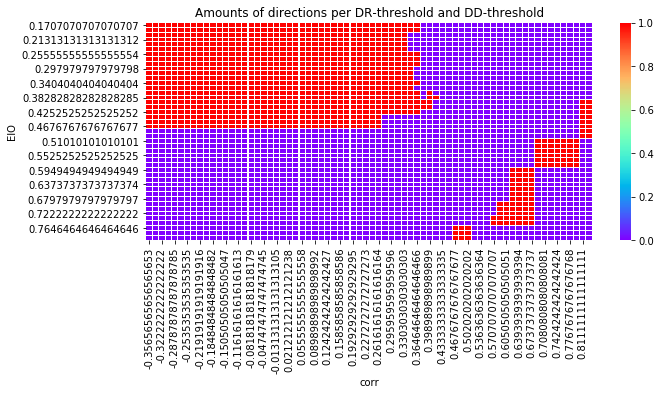

In [511]:
f, ax = plt.subplots(figsize = (10, 4))
#cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
sns.heatmap(pt_cteac.iloc[5:50,20:90], cmap='rainbow', linewidths = 0.05, ax = ax)
ax.set_title('Amounts of directions per DR-threshold and DD-threshold')
ax.set_xlabel('corr')
ax.set_ylabel('EIO');

In [193]:
recalc = True
npzfile_name = data_dir + '/pt_toeacfaoe_0719.npz'
pt_toeacfaoe = None
if recalc == True:
    df_toeacfaoe = combineThresholdsOfEIOAndCorrForAmtOfEdges(
        theta_thresholds_DR, theta_thresholds_corr, FullG)
    pt_toeacfaoe = df_toeacfaoe.pivot_table(
        index = 'theta_EIO', columns='theta_corr',
        values = 'no_edges', aggfunc=np.sum)
    outfile = open(npzfile_name, 'wb')
    np.savez(outfile, ar_toeacfaoe=pt_toeacfaoe,
             col=pt_toeacfaoe.columns, ind=pt_toeacfaoe.index)
    outfile.close()
else:
    infile = open(npzfile_name, 'rb')
    npzfile = np.load(infile)
    infile.close()
    ar_toeacfaoe = npzfile['ar_toeacfaoe']
    pt_toeacfaoe = pd.DataFrame(ar_cteac)
    pt_toeacfaoe.columns = npzfile['col']
    pt_toeacfaoe.index = npzfile['ind']

[0]
1937304 1937302 1937302 1937300 1937300 1937300 1937300 1937300 1937300 1937300 1937298 1937298 1937298 1937296 1937296 1937296 1937294 1937290 1937288 1937284 1937274 1937258 1937236 1937184 1937162 1937126 1937046 1936920 1936790 1936550 1936202 1935780 1935072 1934164 1932710 1930700 1927808 1923604 1917836 1910136 1900398 1887110 1869936 1848492 1821368 1788324 1747624 1699110 1643010 1579352 1507730 1428270 1341714 1249504 1153174 1053396 953640 854648 758480 667122 581218 501864 429824 365006 307600 257472 213750 176268 145026 119142 97334 79716 65272 54046 44916 37584 31734 26932 22952 19678 16814 14094 11806 9648 7782 6102 4602 3286 2196 1350 814 432 204 56 20 8 6 4 0 0 [1]
1937304 1937302 1937302 1937300 1937300 1937300 1937300 1937300 1937300 1937300 1937298 1937298 1937298 1937296 1937296 1937296 1937294 1937290 1937288 1937284 1937274 1937258 1937236 1937184 1937162 1937126 1937046 1936920 1936790 1936550 1936202 1935780 1935072 1934164 1932710 1930700 1927808 1923604 1

10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10070 10069 10067 10064 10064 10060 10060 10055 10048 10032 10015 9988 9947 9895 9835 9748 9620 9458 9245 9007 8742 8417 8072 7697 7254 6763 6309 5777 5227 4709 4207 3737 3279 2858 2502 2205 1914 1654 1408 1189 976 787 623 485 371 254 175 119 64 28 18 11 7 5 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 0 0 0 [28]
9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9268 9267 9265 9262 9262 9258 9258 9253 9246 9230 9215 9188 9150 9102 9046 8966 8849 8695 8493 8270 8028 7727 7397 7038 6619 6156 5725 5236 4725 4250 3780 3349 2942 2546 2229 1955 1701 1472 1252 1060 864 700 551 425 326 224 157 105 57 26 16 11 7 5 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 0 0 0 [29]
7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 7977 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 [91]
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 [92]
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 [93]
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 [94]
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
pt_toeacfaoe.index = [round(i, 4) for i in pt_toeacfaoe.index]
pt_toeacfaoe.columns = [round(i, 4) for i in pt_toeacfaoe.columns]

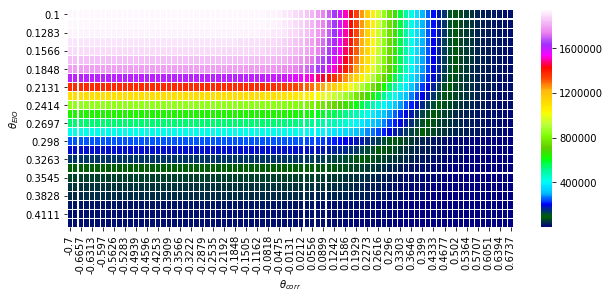

In [683]:
f, ax = plt.subplots(figsize = (10, 4))
#cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
sns.heatmap(pt_toeacfaoe.iloc[:24,:81], cmap='gist_ncar', linewidths = 0.05, ax = ax)
#ax.set_title('Amounts of edges per EIO-threshold and correlation-coefficient-threshold')
ax.set_xlabel(r'$\theta_{corr}$')
ax.set_ylabel(r'$\theta_{EIO}$');
plt.savefig(ROOTPATH + '/Msc/Dissertation/Figures/amounts_of_edges_threshold.pdf', bbox_inches='tight')

## 4. Networks construction
The networks that are studies in this paper represent the set of stocks traded in the NYSE stock market in the U.S., companies which registered out of U.S. are filtered out. As a result, 1418 stocks are considered and analysed with daily logarithmic changes of close prices in 2016.

In [39]:
%%time
threshold_eio = 0.29225
threshold_corr = 0.378705
DiUnwtG = genPureDedirectedGraph(
    threshold_eio, #0.35
    threshold_eio, #0.35
    EIO_direct_requirements_matrix,
    EIO_direct_demands_matrix)

CPU times: user 33.5 s, sys: 294 ms, total: 33.8 s
Wall time: 34.2 s


In [805]:
%%time
G = genWDGraphFromPureDirectedGraph(DiUnwtG, df_stock_normal_return, threshold_corr) # 0.35

CPU times: user 1min 20s, sys: 725 ms, total: 1min 21s
Wall time: 1min 21s


In [41]:
nonodes = G.number_of_nodes()
noedges = G.number_of_edges()
(nonodes, noedges)

(1418, 102051)

In [42]:
nx.density(G)

0.0507891779549755

In [807]:
DiG_pureedge = rmvEdgeAttrOfGraph(G)
DiG_connected = rmvIndepNodesFromGraph(DiG_pureedge)
(DiG_connected.number_of_nodes(), DiG_connected.number_of_edges())

(1320, 102051)

In [808]:
nx.is_weakly_connected(DiG_connected)

True

### Construct a conventional undirected weighted stock network
the number of edges is 1/2 of the directed's

In [1353]:
def genConventionalGraph(theta, return_list):
    global LENTCKR
    global lst_tickers_stp
    G = nx.Graph()
    G.add_nodes_from(lst_tickers_stp)
    for i in range(LENTCKR):
        T1 = lst_tickers_stp[i]
        S1 = return_list[T1]
        for j in range(i+1, LENTCKR):
            T2 = lst_tickers_stp[j]
            S2 = return_list[T2]
            corr = S1.corr(S2)
            if corr > theta: G.add_edge(T1, T2, corr=corr)
    return G

In [1370]:
G_conv = genConventionalGraph(0.4983, df_stock_normal_return)
G_conv.number_of_edges()

51037

0.48-63320<br>
0.49-56323<br>
0.497-51821<br>
0.4975-51530<br>
0.498-51227<br>
0.4982-51094<br>
0.4983-51037<br>
0.4984-50977<br>
0.4985-50914<br>
0.499-50638<br>
0.5-50042

In [1371]:
G_conv.number_of_nodes()

1418

In [1372]:
nx.average_shortest_path_length(G_conv)

NetworkXError: Graph is not connected.

In [1357]:
G.number_of_edges() / 2

51025.5

### Degree distribution

### Log-log linear fitting

1. _out-degree distribution_

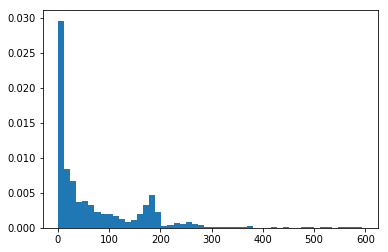

In [1373]:
data = [d for n, d in G.out_degree()]
plt.hist(data, density=1, bins=50, histtype='bar');

In [1376]:
fit = powerlaw.Fit(data)
fit.xmin

Calculating best minimal value for power law fit
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


216.0

In [1377]:
fit.alpha

4.056610150809245

In [1378]:
fit.distribution_compare('power_law', 'lognormal')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(-0.43517715191412254, 0.44283592415009443)

In [1409]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

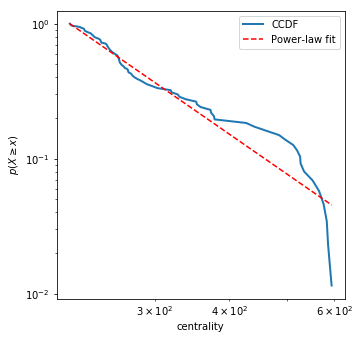

In [1413]:
fig4 = fit.plot_ccdf(linewidth = 2)
fit.power_law.plot_ccdf(ax = fig4, color = 'r', linestyle = '--');
#fit.lognormal.plot_ccdf(ax = fig4, color = 'g', linestyle = '--')
fig4.set_xlabel('centrality')
fig4.set_ylabel('$p(X\geq x)$')
fig4.legend(('CCDF','Power-law fit'))
set_size(4,4,fig4)
plt.savefig(ROOTPATH + '/Msc/Dissertation/Figures/out_degree_log_fit.pdf', bbox_inches='tight')

In [991]:
nx.algorithms.betweenness_centrality(G)

{'A': 0.0006637448251344315,
 'AAL': 3.537113761933398e-05,
 'AAN': 0.0009233008149451807,
 'AAOI': 2.600139188562198e-06,
 'AAON': 0.0006367689067629882,
 'AAPL': 1.0197375979606441e-05,
 'AAT': 0.0,
 'AAWW': 9.624877997619248e-06,
 'ABAX': 0.0,
 'ABBV': 6.338907468956283e-05,
 'ABC': 5.559968969963666e-07,
 'ABCB': 4.2337340913562853e-05,
 'ABCO': 0.0,
 'ABMD': 0.0005858665111762518,
 'ABT': 0.003056756236678063,
 'ACC': 0.0,
 'ACET': 0.00019995661628394266,
 'ACHC': 0.00048498045602162924,
 'ACHN': 0.0006941616721972065,
 'ACIW': 0.0018540128302795206,
 'ACLS': 0.0,
 'ACM': 0.012700581504961395,
 'ACOR': 9.880088974492953e-06,
 'ACRE': 2.4539151691797836e-07,
 'ACXM': 0.0023406922635997567,
 'ADBE': 0.00043980312085095127,
 'ADC': 0.0,
 'ADI': 0.000560641207830001,
 'ADP': 0.006293571667266861,
 'ADS': 0.0002855102719789751,
 'ADTN': 1.3879468892442859e-05,
 'ADUS': 0.0,
 'AE': 1.3312520004040274e-05,
 'AEE': 0.0,
 'AEGN': 0.002729949522533273,
 'AEIS': 0.0001047290472569698,
 'AEL'

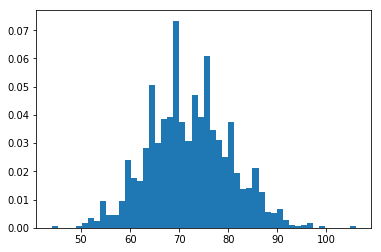

In [1344]:
data = [d for n, d in G_rd.out_degree()]
plt.hist(data, density=1, bins=50, histtype='bar');

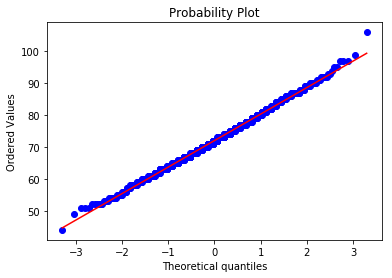

In [1445]:
stats.probplot([d for n, d in G_rd.out_degree()], dist='norm', plot=pylab)
pylab.savefig(ROOTPATH + '/Msc/Dissertation/Figures/G_rd_prob_plot.pdf', bbox_inches='tight')

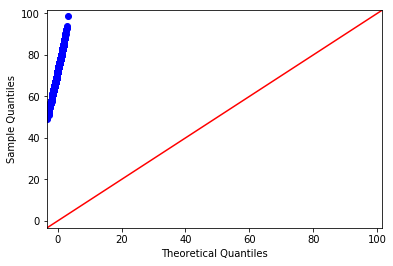

In [1342]:
sm.qqplot(np.array(data), line='45',)
pylab.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


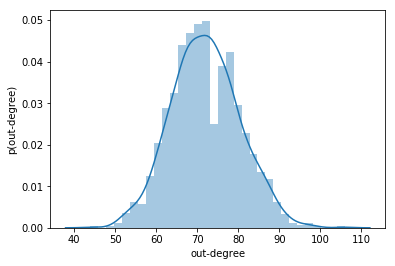

In [1435]:
fig = sns.distplot([d for n, d in G_rd.out_degree()])
fig.set_xlabel('out-degree')
fig.set_ylabel('p(out-degree)');
#plt.savefig(ROOTPATH + '/Msc/Dissertation/Figures/G_rd_out_degree_distribution.pdf', bbox_inches='tight')

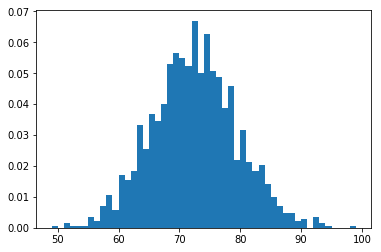

In [1346]:
data = [d for n, d in G_ws_mat.out_degree()]
plt.hist(data, density=1, bins=50, histtype='barstacked');

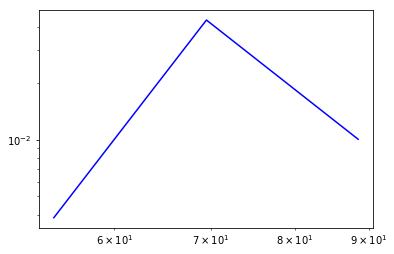

In [938]:
data = [d for n, d in G_ws_mat.out_degree() if d > 0]
powerlaw.plot_pdf(data, linear_bins = False, color = 'b');

In [1418]:
fig = plt.figure()
ax = fig.add_subplot()
ax.

<Figure size 432x288 with 0 Axes>

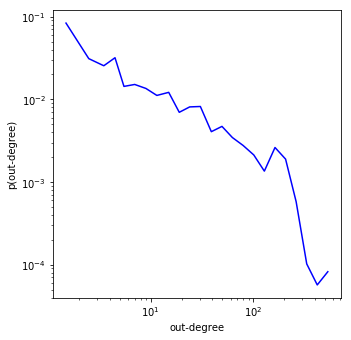

In [1425]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
data = [d for n, d in G.out_degree() if d > 0]
powerlaw.plot_pdf(data, linear_bins = False, color = 'b')
ax.set_xlabel('out-degree')
ax.set_ylabel('p(out-degree)')
set_size(4,4,ax)
plt.savefig(ROOTPATH + '/Msc/Dissertation/Figures/G_out_degree_distribution.pdf', bbox_inches='tight')

2. _in-degree distribution_

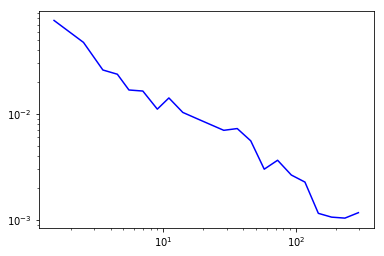

In [922]:
data = [d for n, d in G.in_degree() if d > 0]
powerlaw.plot_pdf(data, linear_bins = False, color = 'b');

3. _total-degree distribution_

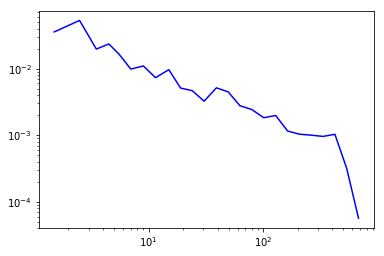

In [811]:
data = [d for n, d in G.degree() if d > 0]
powerlaw.plot_pdf(data, linear_bins = False, color = 'b');

## 5. Topological Properties of the Directed Unweighted Network

Basic discriptions for _Directed Weighted Graph_

In [43]:
print('Number of nodes: %s\nNumber of edges: %s' % (nonodes, noedges))
print('Average degree: %s' % np.average([i[1] for i in nx.degree(G)]))

Number of nodes: 1418
Number of edges: 102051
Average degree: 143.93653032440056


#### Generate small-world graph of the same size
for each v \in V(D)<p>
&emsp;for each u \in V(D)<p>
&emsp;&emsp;if vu \in E(D) and uv \in E(D)<p>
&emsp;&emsp;&emsp;randomly delete from E(D) either uv or vu

In [114]:
p0 = np.average([i[1] for i in G.out_degree()])/(nonodes-1)
ws_mat = watts_strogatz(L=nonodes, p0=p0, beta=0.5, directed=True)
G_ws_mat=nx.from_numpy_matrix(ws_mat, create_using=nx.DiGraph())
G_ws_mat.number_of_edges()

102088

#### Generate random graph of the same size

In [126]:
p = noedges / nonodes / (nonodes-1)
G_rd = nx.generators.gnp_random_graph(nonodes, p=p, directed=True)
G_rd.number_of_edges()

102097

### Average degree

1. _Directed Weighted Graph_

In [967]:
np.average([i[1] for i in nx.degree(G)])

143.93653032440056

2. _Generated Small World Graph_

In [968]:
np.average([i[1] for i in nx.degree(G_ws_mat)])

143.98871650211566

3. _Random Graph_

In [127]:
np.average([i[1] for i in nx.degree(G_rd)])

144.00141043723553

### Average shortest path length

1. _Directed Weighted Graph_

In [827]:
nx.average_shortest_path_length(DiG_connected)

1.9048791554667217

2. _Generated Small World Graph_

In [828]:
nx.average_shortest_path_length(G_ws_mat)

2.0050803610798953

3. _Random Graph_

In [128]:
nx.average_shortest_path_length(G_rd)

1.9733967847605094

In [972]:
%%time
nx.diameter(G_ws_mat)

3

In [973]:
%%time
nx.diameter(G_rd)

CPU times: user 1min 4s, sys: 430 ms, total: 1min 4s
Wall time: 1min 6s


3

### Clustering coefficient

1. _Directed Weighted Graph_

In [830]:
nx.average_clustering(G)

0.4674979220910424

2. _Generated Small World Graph_

In [45]:
nx.average_clustering(G_ws_mat)

0.13669786500810086

3. _Random Graph_

In [832]:
nx.average_clustering(G_rd)

0.051047218422697105

In [1331]:
def calGlobalEfficiency(G, lst_nodes, N): #N = 0, 
    #if N == 0: N = G.number_of_nodes()
    #if lst_nodes == None: lst_nodes = G.nodes()
    shortest_path = nx.shortest_path(G)
    acc = 0.0
    for i in lst_nodes:
        for j in lst_nodes:
            if i != j and (j in shortest_path[i]):
                acc += 1.0/(len(shortest_path[i][j])-1)
    return acc/N/(N-1)

def calLocalEfficiency(G):
    UndiG = G.to_undirected()
    lst_nodes = G.nodes()
    acc = 0.0
    for i in lst_nodes:
        print(i, end='')
        nodes_g = list(UndiG[i])
        n = len(nodes_g)
        if n > 0:
            nodes_g.append(i)
            print('(%s)'%n, end=' ')
            acc += calGlobalEfficiency(G.subgraph(nodes_g), nodes_g, n+1)
    return acc/G.number_of_nodes()

### Global efficiency

1. _Directed Weighted Graph_

In [839]:
%%time
calGlobalEfficiency(DiG_connected, G.number_of_nodes())

CPU times: user 9.83 s, sys: 154 ms, total: 9.98 s
Wall time: 10.3 s


0.2562634585071911

2. _Generated Small World Graph_

In [835]:
%%time
calGlobalEfficiency(G_ws_mat)

CPU times: user 27.1 s, sys: 727 ms, total: 27.9 s
Wall time: 29.2 s


0.5160891372452289

3. _Random Graph_

In [836]:
%%time
calGlobalEfficiency(G_rd)

CPU times: user 17.2 s, sys: 269 ms, total: 17.5 s
Wall time: 18.1 s


0.521565572060238

In [1332]:
%%time
calLocalEfficiency(G)

A(255) AAL(40) AAN(119) AAOI(16) AAON(187) AAPL(61) AAT(3) AAWW(29) ABAX(3) ABBV(33) ABC(16) ABCB(247) ABCOABMD(56) ABT(73) ACC(1) ACET(46) ACHC(97) ACHN(41) ACIW(307) ACLS(1) ACM(553) ACOR(26) ACRE(10) ACXM(118) ADBE(196) ADC(1) ADI(261) ADP(219) ADS(12) ADTN(38) ADUS(1) AE(45) AEE(1) AEGN(234) AEIS(123) AEL(57) AEOAEP(1) AEPIAET(38) AFG(96) AFH(3) AFL(66) AFSI(2) AGCO(168) AGM(142) AGNC(2) AGTC(27) AHPAHT(37) AI(159) AIG(90) AIMC(121) AIN(164) AIZ(20) AJG(92) AKAM(19) AKR(11) AKRX(13) AL(376) ALB(41) ALE(3) ALEX(44) ALG(117) ALGN(107) ALGT(8) ALK(45) ALL(56) ALOG(90) ALSN(171) ALX(1) ALXN(12) AMAG(38) AMAT(210) AMBA(42) AMCX(12) AME(233) AMED(30) AMG(289) AMGN(68) AMKR(23) AMNB(208) AMP(297) AMSF(18) AMSWA(14) AMT(6) AMTD(264) AMZN(4) ANAT(77) ANCX(172) ANF(2) ANH(2) ANIK(19) ANIP(35) ANSS(225) ANTM(26) AOSL(3) AP(32) APAM(229) APH(300) APOG(247) ARCB(176) ARE(8) ARI(3) ARII(147) AROW(260) ARRS(93) ARRY(1) ARTNAARW(579) ASGN(584) ASTE(107) ATHN(8) ATLO(150) ATNI(3) ATO(2) ATR(108) AT

PDLIPDM(225) PEB(40) PEBO(207) PEG(1) PEGA(141) PETS(62) PFE(25) PFG(91) PFIS(137) PFS(294) PFSI(1) PGC(168) PGNX(40) PGR(54) PGTI(32) PHIIK(4) PHM(167) PJC(206) PKE(5) PKI(226) PKY(1) PLABPLCEPLD(13) PLKI(7) PLOW(18) PLPC(1) PLPMPLT(77) PLUS(91) PLXS(216) PMC(4) PMT(1) PNC(281) PNFP(285) PNKPNM(1) PNW(1) POL(117) POR(1) POWI(203) POWL(22) PPBI(216) PPC(5) PPG(96) PPL(1) PRA(33) PRFT(7) PRGS(156) PRI(82) PRIM(146) PRK(288) PRU(87) PRXL(144) PSA(1) PSB(5) PSTB(207) PSX(79) PTSI(7) PWOD(196) PWR(170) PYPL(24) PZN(184) PZZAQADA(4) QCOM(131) QLYS(30) QRVO(184) QSIIRADRAI(1) RAIL(85) RAS(26) RAVN(68) RBC(275) RBCAA(230) RDC(29) RDN(55) RDNT(82) RECN(8) REGN(40) REIS(6) REXR(12) RF(262) RGA(91) RGEN(49) RH(1) RHI(354) RHP(40) RJF(262) RLGY(216) RLI(41) RLJ(47) RM(165) RMAX(291) RMBS(170) RMD(17) RNST(297) ROG(7) ROIC(2) ROK(218) ROLL(236) ROP(188) ROST(6) RP(73) RPAI(1) RPM(121) RPT(10) RPXC(110) RRGB(5) RRTS(51) RS(442) RSG(70) RSORTEC(91) RTIX(27) RTN(13) RTRX(18) RUTH(12) RWT(20) RYN(33) 

0.6276046427894616

In [1333]:
%%time
calLocalEfficiency(G_ws_mat)

0(132) 1(121) 2(125) 3(127) 4(123) 5(117) 6(123) 7(141) 8(147) 9(120) 10(126) 11(132) 12(138) 13(121) 14(122) 15(119) 16(114) 17(117) 18(118) 19(123) 20(138) 21(108) 22(135) 23(123) 24(119) 25(123) 26(120) 27(125) 28(114) 29(125) 30(133) 31(132) 32(127) 33(118) 34(113) 35(138) 36(123) 37(114) 38(127) 39(141) 40(133) 41(110) 42(113) 43(124) 44(122) 45(126) 46(122) 47(127) 48(130) 49(136) 50(125) 51(121) 52(123) 53(120) 54(114) 55(130) 56(134) 57(128) 58(127) 59(135) 60(121) 61(119) 62(120) 63(120) 64(113) 65(130) 66(127) 67(123) 68(119) 69(116) 70(123) 71(125) 72(126) 73(119) 74(109) 75(119) 76(123) 77(130) 78(138) 79(126) 80(132) 81(123) 82(134) 83(130) 84(111) 85(127) 86(124) 87(127) 88(123) 89(121) 90(134) 91(140) 92(131) 93(134) 94(138) 95(129) 96(132) 97(114) 98(131) 99(126) 100(122) 101(122) 102(126) 103(133) 104(120) 105(131) 106(112) 107(123) 108(115) 109(129) 110(114) 111(119) 112(111) 113(122) 114(127) 115(127) 116(119) 117(126) 118(141) 119(111) 120(133) 121(107) 122(120) 123

923(126) 924(125) 925(122) 926(117) 927(124) 928(125) 929(126) 930(126) 931(134) 932(122) 933(135) 934(115) 935(112) 936(129) 937(127) 938(117) 939(112) 940(113) 941(122) 942(126) 943(114) 944(137) 945(117) 946(123) 947(124) 948(128) 949(130) 950(104) 951(117) 952(122) 953(112) 954(116) 955(127) 956(140) 957(117) 958(117) 959(139) 960(115) 961(131) 962(108) 963(123) 964(124) 965(125) 966(146) 967(120) 968(126) 969(126) 970(119) 971(122) 972(102) 973(116) 974(124) 975(135) 976(124) 977(127) 978(126) 979(123) 980(130) 981(127) 982(115) 983(119) 984(124) 985(122) 986(128) 987(121) 988(125) 989(124) 990(129) 991(125) 992(115) 993(127) 994(119) 995(129) 996(114) 997(107) 998(122) 999(114) 1000(110) 1001(132) 1002(120) 1003(114) 1004(121) 1005(130) 1006(110) 1007(122) 1008(132) 1009(127) 1010(121) 1011(124) 1012(131) 1013(105) 1014(120) 1015(114) 1016(126) 1017(119) 1018(128) 1019(136) 1020(124) 1021(132) 1022(122) 1023(120) 1024(130) 1025(118) 1026(143) 1027(118) 1028(132) 1029(135) 1030(12

0.5026505969359318

In [1334]:
%%time
calLocalEfficiency(G_rd)

0(132) 1(151) 2(150) 3(152) 4(154) 5(137) 6(164) 7(133) 8(129) 9(147) 10(149) 11(145) 12(153) 13(122) 14(134) 15(136) 16(149) 17(131) 18(141) 19(147) 20(149) 21(146) 22(156) 23(133) 24(121) 25(146) 26(149) 27(156) 28(133) 29(130) 30(145) 31(132) 32(141) 33(124) 34(140) 35(141) 36(137) 37(141) 38(159) 39(130) 40(131) 41(127) 42(159) 43(137) 44(133) 45(151) 46(142) 47(142) 48(150) 49(158) 50(152) 51(148) 52(149) 53(123) 54(154) 55(139) 56(132) 57(135) 58(156) 59(162) 60(126) 61(132) 62(137) 63(134) 64(149) 65(129) 66(145) 67(137) 68(143) 69(133) 70(143) 71(141) 72(140) 73(150) 74(140) 75(141) 76(132) 77(144) 78(135) 79(146) 80(133) 81(143) 82(155) 83(156) 84(164) 85(140) 86(153) 87(141) 88(143) 89(147) 90(150) 91(128) 92(143) 93(118) 94(151) 95(145) 96(125) 97(137) 98(146) 99(141) 100(147) 101(153) 102(144) 103(139) 104(135) 105(136) 106(129) 107(150) 108(133) 109(167) 110(136) 111(139) 112(152) 113(141) 114(134) 115(134) 116(142) 117(148) 118(120) 119(145) 120(132) 121(155) 122(140) 123

923(139) 924(133) 925(148) 926(137) 927(137) 928(131) 929(147) 930(135) 931(131) 932(146) 933(145) 934(151) 935(137) 936(122) 937(126) 938(143) 939(139) 940(150) 941(160) 942(138) 943(148) 944(124) 945(139) 946(136) 947(153) 948(136) 949(145) 950(124) 951(138) 952(140) 953(138) 954(129) 955(171) 956(114) 957(150) 958(154) 959(142) 960(144) 961(132) 962(147) 963(142) 964(138) 965(132) 966(126) 967(152) 968(141) 969(114) 970(149) 971(120) 972(146) 973(168) 974(140) 975(159) 976(141) 977(145) 978(149) 979(147) 980(145) 981(133) 982(116) 983(147) 984(149) 985(134) 986(128) 987(151) 988(139) 989(131) 990(160) 991(146) 992(144) 993(135) 994(145) 995(145) 996(134) 997(126) 998(139) 999(141) 1000(155) 1001(134) 1002(137) 1003(147) 1004(123) 1005(151) 1006(134) 1007(134) 1008(153) 1009(140) 1010(169) 1011(132) 1012(131) 1013(139) 1014(141) 1015(142) 1016(141) 1017(135) 1018(122) 1019(166) 1020(127) 1021(137) 1022(145) 1023(158) 1024(131) 1025(143) 1026(140) 1027(129) 1028(136) 1029(144) 1030(13

0.4455981483466167

In [1335]:
SendEmail('LocalEfficiency Done!')

Email sent!


### Degree distribution

#### Fit a power law to the degree distribution of network

### In-Out Degree Ratio & Counted by Industries

In [ ]:
[print(i[0]) for i in out_degree if i[1] == sorted(lst_out_degree, reverse=True)[0]]

In [ ]:
def getRangeDegreeCountOfIndustries(degree_view, theta_low_mid, theta_mid_high):
    df = pd.DataFrame(index=np.unique(df_codes_and_title['Title']),
                      columns=[
                          'Entire', 'Zero Degree',
                          'Low Degree', 'Mid Degree',
                          'High Degree'], data=0)
    df_perc = df.copy()
    df.index.name = 'Amount of degrees'
    df_perc.index.name = 'Percentage of degrees'
    lst_value_counts = [pd.DataFrame()] * 5
    lst_value_counts[0] = pd.Series(getIndustryCodeByStockCode(
        [i[0] for i in degree_view],
        code_type='Title')).value_counts()
    lst_value_counts[1] = pd.Series(getIndustryCodeByStockCode(
        [i[0] for i in degree_view if i[1] == 0],
        code_type='Title')).value_counts()
    lst_value_counts[2] = pd.Series(getIndustryCodeByStockCode(
        [i[0] for i in degree_view if i[1] > 0 and i[1] < theta_low_mid],
        code_type='Title')).value_counts()
    lst_value_counts[3] = pd.Series(getIndustryCodeByStockCode(
        [i[0] for i in degree_view if i[1] >= theta_low_mid and i[1] < theta_mid_high],
        code_type='Title')).value_counts()
    lst_value_counts[4] = pd.Series(getIndustryCodeByStockCode(
        [i[0] for i in degree_view if i[1] >= theta_mid_high],
        code_type='Title')).value_counts()
    for i in range(len(lst_value_counts)):
        value_counts = lst_value_counts[i]
        for key, value in value_counts.iteritems():
            df.ix[key, i] = value
            df_perc.ix[key, i] = float(value) / sum(lst_value_counts[i])
    return df, df_perc

In [ ]:
overall_degree_WGD_NR = WGD_NR.degree()

In [ ]:
df_range_degree_count_of_industries, df_perc = getRangeDegreeCountOfIndustries(overall_degree_WGD_NR, 200, 1000)

In [ ]:
df_range_degree_count_of_industries

Calculate the **in- and out-degree ratio**: the number of in-degrees divided by the number of out-degrees of a node. Apply to both weighted and unweighted networks.

In [ ]:
def CalInOutDegreeRatio(G):
    arr_ratio = np.array([0.0] * len(lst_tickers_stp))
    for i in range(len(lst_tickers_stp)):
        tckr = lst_tickers_stp[i]
        in_degree = G.in_degree[tckr]
        out_degree = G.out_degree[tckr]
        if in_degree > 0 and out_degree > 0:
            arr_ratio[i] = float(in_degree) / out_degree
        elif out_degree == 0:
            if in_degree == 0: arr_ratio[i] = -1
            else: arr_ratio[i] = np.inf
    return arr_ratio

Get the descriptive statistics of two kinds of IOD-Ratios, both the mean and variance values decrease, indicates more in-degrees are eliminated by the correlation coefficient threshold.

In [ ]:
arr_in_out_ratio_Unwt = CalInOutDegreeRatio(DiUnwtG)
arr_in_out_ratio_Wt_NmRt = CalInOutDegreeRatio(DiWtG_NmRt)
print(describe(arr_in_out_ratio_Unwt[(arr_in_out_ratio_Unwt!=-1) & (arr_in_out_ratio_Unwt!=np.inf)]))
print(describe(arr_in_out_ratio_Wt_NmRt[(arr_in_out_ratio_Wt_NmRt!=-1) & (arr_in_out_ratio_Wt_NmRt!=np.inf)]))

Interestingly, when use directed weighted network to generate the in- and out-degree ratio, there are many nodes have complete balanced in- and out-degree, while there are none nodes with ratio of exactly 1 for directed unweighted network.

In [ ]:
print('Number of nodes with in- and out-degree ratio of 1 for DCN: %s' % sum(np.array(arr_in_out_ratio_Unwt)==1))
print('Number of nodes with in- and out-degree ratio of 1 for DWCN: %s' % sum(np.array(arr_in_out_ratio_Wt_NmRt)==1))

In [ ]:
def getTickersByArrayValue(arr, val):
    return [lst_tickers_stp[i] for i in np.arange(len(arr))[arr==val]]

In [ ]:
lst_tckr_IODR_1_Wt = [lst_tickers_stp[i] for i in np.arange(len(arr_in_out_ratio_Wt_NmRt))[arr_in_out_ratio_Wt_NmRt==1]]
lst_tckr_IODR_b1_Wt = [lst_tickers_stp[i] for i in np.arange(len(arr_in_out_ratio_Wt_NmRt))[arr_in_out_ratio_Wt_NmRt>1]]
lst_tckr_IODR_s1_Wt = [lst_tickers_stp[i] for i in np.arange(len(arr_in_out_ratio_Wt_NmRt))[arr_in_out_ratio_Wt_NmRt<1]]

lst_IndTtl_IODR_1_Wt_NmRt = getIndustryCodeByStockCode(
    stock_code_list=lst_tckr_IODR_1_Wt,
    code_type='Title')
lst_IndTtl_IODR_b1_Wt_NmRt = getIndustryCodeByStockCode(
    stock_code_list=lst_tckr_IODR_b1_Wt,
    code_type='Title')
lst_IndTtl_IODR_s1_Wt_NmRt = getIndustryCodeByStockCode(
    stock_code_list=lst_tckr_IODR_s1_Wt,
    code_type='Title')

In [ ]:
lst_prev_val_in_Unwt_IODR_1 = arr_in_out_ratio_Unwt[[lst_tickers_stp.index(tckr) for tckr in lst_tckr_IODR_1_Wt]]

In [ ]:
describe(lst_prev_val_in_Unwt_IODR_1)

In [ ]:
def pltIndBarChartByList(industry_list, save_file=False, filename_postfix='0'):
    uniq_ind = np.unique(lst_IndTtl_IODR_1_Wt_NmRt)
    idx = np.arange(len(uniq_ind))
    lst_agg = [sum(np.array(industry_list)==ind) for ind in uniq_ind]
    plt.figure(figsize=(15,4))
    plt.bar(idx, lst_agg)
    plt.xticks(idx, uniq_ind, rotation=90)
    if save_file:
        plt.savefig(ROOTPATH + '/IndBarChart_%s.pdf' % filename_postfix, bbox_inches='tight')

#### Plot bar chart of industries with the number of nodes with IOD-Ratio equals to 1

In [ ]:
pltIndBarChartByList(lst_IndTtl_IODR_1_Wt_NmRt)

In [ ]:
pltIndBarChartByList(lst_IndTtl_IODR_b1_Wt_NmRt)

In [ ]:
pltIndBarChartByList(lst_IndTtl_IODR_s1_Wt_NmRt)

In [ ]:
uniq_ind = np.unique(getIndustryCodeByStockCode(lst_tickers_stp, code_type='Title'))
idx = np.arange(len(uniq_ind))
lst_agg_s1 = [sum(np.array(lst_IndTtl_IODR_s1_Wt_NmRt)==ind) for ind in uniq_ind]
lst_agg_1 = [sum(np.array(lst_IndTtl_IODR_1_Wt_NmRt)==ind) for ind in uniq_ind]
lst_agg_b1 = [sum(np.array(lst_IndTtl_IODR_b1_Wt_NmRt)==ind) for ind in uniq_ind]
plt.figure(figsize=(15,6))
p1 = plt.bar(idx, lst_agg_s1, color='r')
p2 = plt.bar(idx, lst_agg_1, bottom=lst_agg_s1, color='b')
p3 = plt.bar(idx, lst_agg_b1, 
             bottom=np.array(lst_agg_s1)+np.array(lst_agg_1), color='g')
plt.xticks(idx, uniq_ind, rotation=90)
plt.legend((p1[0], p2[0], p3[0]), ('Smaller than 1', 'Equal to 1', 'Bigger than 1'));
plt.savefig(ROOTPATH + '/IndStackedBarChart_00.pdf', bbox_inches='tight')

In [ ]:
industry_0 = ['Fabricated metal products', 'Legal services', 'Mining, except oil and gas', 'Miscellaneous manufacturing', 'Motion picture and sound recording industries', 'Other services, except government', 'Securities, commodity contracts, and investments', 'Truck transportation', 'Utilities', 'Water transportation']
industry_1 = ['Administrative and support services', 'Ambulatory health care services', 'Ambulatory health care services', 'Broadcasting and telecommunications', 'Chemical products', 'Computer and electronic products', 'Computer systems design and related services', 'Construction', 'Federal Reserve banks, credit intermediation, and related activities', 'Food and beverage and tobacco products', 'Hospitals', 'Insurance carriers and related activities', 'Machinery', 'Miscellaneous professional, scientific, and technical services', 'Motor vehicles, bodies and trailers, and parts', 'Other real estate', 'Other retail', 'Rental and leasing services and lessors of intangible assets', 'Wholesale trade']
industry_2 = ['Accommodation', 'Air transportation', 'Apparel and leather and allied products', 'Data processing, internet publishing, and other information services', 'Electrical equipment, appliances, and components', 'Funds, trusts, and other financial vehicles', 'Furniture and related products', 'Nonmetallic mineral products', 'Oil and gas extraction', 'Other transportation and support activities', 'Other transportation equipment', 'Paper products', 'Performing arts, spectator sports, museums, and related activities', 'Petroleum and coal products', 'Pipeline transportation', 'Plastics and rubber products', 'Primary metals', 'Printing and related support activities', 'Publishing industries, except internet (includes software)', 'Rail transportation', 'Social assistance', 'Support activities for mining', 'Textile mills and textile product mills', 'Transit and ground passenger transportation', 'Waste management and remediation services', 'Wood products']

In [ ]:
print(industry_0)
print(industry_1)
print(industry_2)

### Community Structure


1. construct the modularity matrix according to the equation: $B_{ij}=A_{ij}-\frac{k_i^{in}k_j^{out}}{m}$, $A_{ij}$
is defined in the conventional manner to be 1 if there is an edge from j to i and zero otherwise, $m$ is the total number of edges in the network;
2. find the most positive eigenvalue of the symmetric matrix $B+B^T$ and the corresponding eigenvector;
3. each vertex is assigned to one of two groups depending on the sign of the appropriate element of the eigenvector, and then fine-tune the assignments as described above to maximize the modularity;
4. further subdivide the communities using the same method, but with the generalized modularity matrix, $B_{ij}^{(g)}$, fine-tuning after each division.

In [992]:
def detectCommunityForDirectedGraph(G):
    lst_node = list(G.nodes)
    NONODES = G.number_of_nodes()
    NOEDGES = G.number_of_edges()
    NOINDEGREES = G.in_degree()
    NOOUTDEGREES = G.out_degree()
    overall_asgn = [(0, 0)] * NONODES
    
    def getNodeSpace(node_space, upd_asgn, val):
        return [node_space[i] for i in range(len(upd_asgn)) if upd_asgn[i] == val]
    '''
    def fineTune(node_space, upd_asgn):
        nonlocal G
        nonlocal overall_asgn
        nonlocal NONODES
        for i in upd_asgn:
            for j in node_space:
'''
    def interateBisection(mod_mat, node_space, generation_mark):
        nonlocal G
        nonlocal overall_asgn
        upd_asgn = subdivideCommunities(mod_mat)
        # todo: fine-tune
        
        if len(np.unique(upd_asgn)) == 1: return
        delta_Q = calDeltaQ(upd_asgn, mod_mat)
        print('calDeltaQ: %s' % delta_Q)
        if delta_Q < 0: return
        node_space_1 = getNodeSpace(node_space, upd_asgn, -1)
        if len(node_space_1) == 0: return
        updCommunityAssignment(node_space_1, upd_asgn, generation_mark)
        print('genGeneralisedModularityMatrix_1: %s:%s:%s' % (time.localtime()[3],time.localtime()[4],time.localtime()[5]))
        mod_mat_1 = genGeneralisedModularityMatrix(node_space_1)
        interateBisection(mod_mat_1, node_space_1, generation_mark+1)
        node_space_2 = getNodeSpace(node_space, upd_asgn, 1)
        if len(node_space_2) == 0: return
        updCommunityAssignment(node_space_2, upd_asgn, generation_mark)
        print('genGeneralisedModularityMatrix_2: %s:%s:%s' % (time.localtime()[3],time.localtime()[4],time.localtime()[5]))
        mod_mat_2 = genGeneralisedModularityMatrix(node_space_2)
        interateBisection(mod_mat_2, node_space_2, generation_mark+1)
        return
    
    def genGeneralisedModularityMatrix(node_space):# Subgraph
        nonlocal G
        nonlocal lst_node
        nonlocal NOEDGES
        nonlocal NOINDEGREES
        nonlocal NOOUTDEGREES
        nonlocal overall_asgn
        LENNODESPECE = len(node_space)
        mod_mat = np.matrix(np.zeros((LENNODESPECE, LENNODESPECE), dtype=np.float64))
        for i in range(LENNODESPECE):
            print(i, end=' ')
            tckr_i = lst_node[node_space[i]]
            for j in range(LENNODESPECE):
                tckr_j = lst_node[node_space[j]]
                Bij = G.has_edge(tckr_j, tckr_i) - NOINDEGREES[tckr_i] * NOOUTDEGREES[tckr_j] / NOEDGES
                if overall_asgn[node_space[i]] == overall_asgn[node_space[j]]:
                    Ck = 0.0
                    for k in node_space:
                        tckr_k = lst_node[k]
                        Ck += G.has_edge(tckr_k, tckr_i) + G.has_edge(tckr_i, tckr_k) - (NOINDEGREES[tckr_i] * NOOUTDEGREES[tckr_k] + NOINDEGREES[tckr_k] * NOOUTDEGREES[tckr_i]) / NOEDGES
                    mod_mat[i, j] = Bij - Ck / 2.0
                else: mod_mat[i, j] = Bij
        print('/')
        return mod_mat
    
    def updCommunityAssignment(node_space, upd_asgn, generation_mark):
        nonlocal overall_asgn
        global asgn_history
        inreval_1 = 0
        inreval_2 = 0
        lst_gener_asgn = []
        for asgn in overall_asgn:
            if asgn[0] == generation_mark:
                lst_gener_asgn.append(asgn[1])
        for i in range(len(node_space)):
            if i not in lst_gener_asgn:
                inreval_1 = i
                break
        if upd_asgn.count(1) == 0: inreval_2 = inreval_1
        else:
            for i in range(len(node_space)):
                if i not in lst_gener_asgn:
                    inreval_2 = i
                    break
        for i in range(len(node_space)):
            if upd_asgn[i] == 1: overall_asgn[node_space[i]] = (generation_mark, inreval_1)
            if upd_asgn[i] == -1: overall_asgn[node_space[i]] = (generation_mark, inreval_2)
        #print(overall_asgn)
        asgn_history.append(overall_asgn.copy())
    
    def subdivideCommunities(mod_mat):
        sym_mat = mod_mat + mod_mat.T
        w, v = np.linalg.eigh(sym_mat)
        eigv = v[:, len(w)-1]
        return [np.sign(v.tolist()[0][0]) for v in eigv]
        
    def calDirectedGraphModularity(assignment):
        nonlocal G
        nonlocal lst_node
        nonlocal NONODES
        nonlocal NOEDGES
        nonlocal NOINDEGREES
        nonlocal NOOUTDEGREES
        Q = 0.0
        for i in range(NONODES):
            for j in range(NONODES):
                if assignment[i] == assignment[j]:
                    Q += G.has_edge(lst_node[j], lst_node[i]) - NOINDEGREES[lst_node[i]] * NOOUTDEGREES[lst_node[j]] / NOEDGES
        return Q / NOEDGES
    
    def calDeltaQ(upd_asgn, Bg):
        nonlocal NOEDGES
        sg = np.matrix(upd_asgn)
        return 0.25/NOEDGES*np.dot(np.dot(sg, (Bg+Bg.T)), sg.T)[0,0]
    
    MODMAT = np.matrix(np.zeros((NONODES, NONODES), dtype=np.float64))
    for i in range(NONODES):
        for j in range(NONODES):
            MODMAT[i, j] = G.has_edge(lst_node[j], lst_node[i]) - NOINDEGREES[lst_node[i]] * NOOUTDEGREES[lst_node[j]] / NOEDGES
    interateBisection(MODMAT, list(np.arange(NONODES)), 1)
    return overall_asgn, calDirectedGraphModularity(overall_asgn)

In [1493]:
def calModularity(assignment):
    global G
    global lst_node
    global NONODES
    global NOEDGES
    global NOINDEGREES
    global NOOUTDEGREES
    Q = 0.0
    for i in range(NONODES):
        for j in range(NONODES):
            if assignment[i] == assignment[j]:
                Q += G.has_edge(lst_node[j], lst_node[i]) - NOINDEGREES[lst_node[i]] * NOOUTDEGREES[lst_node[j]] / NOEDGES
    return Q / NOEDGES

In [1494]:
lst_node = list(G.nodes())
NONODES = G.number_of_nodes()
NOEDGES = G.number_of_edges()
NOINDEGREES = G.in_degree()
NOOUTDEGREES = G.out_degree()

In [ ]:
over_best_asgn = best_asgn.copy()

In [132]:
int(G.node['A']['community'])

1

In [18]:
over_best_asgn = [0] * len(lst_tickers_stp)
for i in range(len(lst_tickers_stp)):
    over_best_asgn[i] = int(G.node[lst_tickers_stp[i]]['community'])

In [1521]:
%%time
best_asgn = over_best_asgn.copy()
origin_mod = calModularity(best_asgn)
print('origin_mod: %s'%origin_mod)
for i in range(len(best_asgn)):
    asgn = best_asgn[i]
    for uniq in uniq_asgn:
        print('.',end='')
        if asgn != uniq:
            best_asgn[i] = uniq
            new_mod = calModularity(best_asgn)
            if new_mod > origin_mod:
                origin_mod = new_mod
                print('new_mod: %s'%origin_mod)
                print('%s - %s'%(str(asgn),str(uniq)))
                asgn = uniq
            else: best_asgn[i] = asgn
    print('/',end='')

origin_mod: 0.42177086888257115
........................./........................./........................./........................./........................./........................./........new_mod: 0.4217787689966297
(8, 6) - (6, 2)
................./........................./.new_mod: 0.42178120927008683
(6, 2) - (0, 0)
..new_mod: 0.4218155268278408
(0, 0) - (3, 0)
....................../........................./........................./........................./........................./........................./....new_mod: 0.42188502238603315
(6, 3) - (4, 0)
.new_mod: 0.42219129840560865
(4, 0) - (4, 1)
..................../........................./....new_mod: 0.42219888088275026
(6, 2) - (4, 0)
...................../.....new_mod: 0.4222756477145658
(6, 0) - (4, 1)
...new_mod: 0.42229695925045113
(4, 1) - (6, 2)
................./........................./........................./.new_mod: 0.4222978523402213
(6, 2) - (0, 0)
..new_mod: 0.4223115186013397
(0, 0) - (3, 0)


...new_mod: 0.4276086760980267
(0, 0) - (4, 0)
...................../........................./........................./........................./........................./....new_mod: 0.4278396202211191
(6, 2) - (4, 0)
...................../........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./.new_mod: 0.4278401943296813
(6, 0) - (0, 0)
..new_mod: 0.4278507075546973
(0, 0) - (3, 0)
.new_mod: 0.4278551610969654
(3, 0) - (4, 0)
....new_mod: 0.4278945272380917
(4, 0) - (6, 2)
................./........................./.new_mod: 0.4278945275261542
(10, 0) - (0, 0)
.......new_mod: 0.42791288718958265
(0, 0

...................../........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./...new_mod: 0.43138087162535327
(4, 0) - (3, 0)
....................../........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........new_mod: 0.4314228232234362
(4, 0) - (6, 2)
................./...new_mod: 0.4314309339111832
(4, 0) - (3, 0)
....................../........................./........................./........................./........................./....new_mod: 0.43146204197258453
(6, 3) - (4, 0)
.new_mod: 0.43149880287646153
(4, 0) - (4,

....................../........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./....new_mod: 0.4329908655157804
(3, 0) - (4, 0)
...................../........................./........................./.......................

....................../........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./........................./.new_mod: 0.435172277176618
(6, 2) - (0, 0)
...new_mod: 0.4352050655065811
(0, 0) - (4, 0)
...................../........................./........................./........................./CPU times: user 8h 31min 55s, sys: 1min 44s, total: 8h 33min 39s
Wall time: 8h 36min 7s


In [371]:
lst_tckr_nonzero = [i[0] for i in G.degree if i[1]>0]
rdmchosen_tickers = np.random.choice(lst_tckr_nonzero, 1, replace=False)
nonzerodeg_subG = G.subgraph(lst_tckr_nonzero).copy()

In [303]:
asgn_history = []
overall_asgn, modularity = detectCommunityForDirectedGraph(nonzerodeg_subG)

calDeltaQ: 0.09622760583097827
genGeneralisedModularityMatrix_1: 11:51:38
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [391]:
len(asgn_history)

92

In [310]:
asgn_history_sample = asgn_history.copy()

In [311]:
overall_asgn_sample = overall_asgn
modularity_sample = modularity

In [993]:
asgn_history = []
overall_asgn, modularity = detectCommunityForDirectedGraph(G)

calDeltaQ: 0.4065297384868255
genGeneralisedModularityMatrix_1: 22:41:3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 25

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 /
calDeltaQ: -0.043998165479346825
genGeneralisedModularityMatrix_2: 23:35:34
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 16

calDeltaQ: 0.0006867623642919065
genGeneralisedModularityMatrix_1: 0:15:31
0 1 2 3 4 5 6 7 8 9 /
calDeltaQ: -0.00012395502206299924
genGeneralisedModularityMatrix_2: 0:15:31
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 /
calDeltaQ: 0.00025570141459085134
genGeneralisedModularityMatrix_1: 0:15:31
0 1 2 3 /
calDeltaQ: 9.632089838932148e-06
genGeneralisedModularityMatrix_1: 0:15:31
0 1 /
genGeneralisedModularityMatrix_2: 0:15:31
0 1 /
genGeneralisedModularityMatrix_2: 0:15:31
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 /
genGeneralisedModularityMatrix_2: 0:15:31
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 /
calDeltaQ: 0.10781703106273793
genGeneralisedModularityMatrix_1: 0:24:13
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 /
calDeltaQ: -0.03593801378602426
genGeneralisedModularityMatrix_2: 0:24:13
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 /
calDeltaQ: 0.010048846277036194
genGeneralisedModularityMatr

In [40]:
pd.Series(getIndustryCodeByStockCode([lst_tickers_stp[i] for i in range(len(over_best_asgn)) if over_best_asgn[i]==5],'Title')).value_counts()

Funds, trusts, and other financial vehicles    59
Utilities                                      44
Other real estate                               1
dtype: int64

In [27]:
sri_overall_asgn = pd.Series(over_best_asgn)
uniq_asgn = np.unique(sri_overall_asgn)
v_c_2 = sri_overall_asgn.value_counts()

In [150]:
over_best_asgn

[1,
 3,
 3,
 1,
 1,
 1,
 7,
 3,
 1,
 4,
 4,
 2,
 2,
 3,
 4,
 5,
 3,
 7,
 4,
 1,
 1,
 1,
 4,
 2,
 1,
 1,
 5,
 1,
 1,
 3,
 1,
 10,
 2,
 5,
 1,
 1,
 4,
 6,
 5,
 6,
 4,
 4,
 4,
 4,
 7,
 1,
 2,
 5,
 4,
 6,
 2,
 2,
 4,
 3,
 3,
 4,
 4,
 3,
 7,
 4,
 3,
 3,
 5,
 2,
 1,
 3,
 3,
 3,
 4,
 1,
 1,
 7,
 4,
 4,
 1,
 1,
 1,
 1,
 7,
 2,
 4,
 1,
 2,
 2,
 4,
 1,
 7,
 2,
 1,
 4,
 2,
 7,
 5,
 1,
 4,
 1,
 4,
 1,
 1,
 2,
 1,
 1,
 3,
 2,
 2,
 1,
 2,
 1,
 4,
 6,
 3,
 3,
 1,
 3,
 2,
 11,
 5,
 3,
 6,
 1,
 3,
 1,
 5,
 1,
 5,
 1,
 1,
 3,
 1,
 5,
 6,
 3,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 3,
 6,
 13,
 3,
 2,
 6,
 6,
 3,
 1,
 2,
 7,
 3,
 4,
 1,
 2,
 1,
 7,
 2,
 7,
 8,
 2,
 1,
 2,
 3,
 4,
 1,
 8,
 2,
 2,
 5,
 2,
 2,
 3,
 2,
 1,
 1,
 8,
 6,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 6,
 2,
 1,
 1,
 4,
 3,
 1,
 2,
 4,
 3,
 4,
 2,
 1,
 4,
 2,
 3,
 1,
 2,
 1,
 2,
 2,
 3,
 4,
 8,
 1,
 2,
 3,
 1,
 3,
 2,
 2,
 6,
 2,
 4,
 8,
 1,
 2,
 2,
 3,
 2,
 5,
 1,
 1,
 2,
 7,
 1,
 7,
 1,
 1,
 4,
 7,
 1,
 6,
 2,
 2,
 6,
 2,
 1,
 1,
 

In [29]:
for i in range(len(v_c_2)): v_c_2[i] = i+1

In [32]:
for i in range(len(lst_tickers_stp)): G.nodes[lst_tickers_stp[i]]['community'] = str(v_c_2[over_best_asgn[i]])

In [33]:
v_c = pd.Series(sri_overall_asgn).value_counts()

In [41]:
stp_group_tckr_index = sri_overall_asgn[sri_overall_asgn == v_c.index[0]].index.tolist()
stp_group_tckr = [lst_tickers_stp[i] for i in stp_group_tckr_index]
stp_group_indcode = getIndustryCodeByStockCode(stp_group_tckr, code_type='Title')
sri_community_1 = pd.Series(stp_group_indcode).value_counts()
stp_group_tckr_index = sri_overall_asgn[sri_overall_asgn == v_c.index[1]].index.tolist()
stp_group_tckr = [lst_tickers_stp[i] for i in stp_group_tckr_index]
stp_group_indcode = getIndustryCodeByStockCode(stp_group_tckr, code_type='Title')
sri_community_2 = pd.Series(stp_group_indcode).value_counts()
stp_group_tckr_index = sri_overall_asgn[sri_overall_asgn == v_c.index[2]].index.tolist()
stp_group_tckr = [lst_tickers_stp[i] for i in stp_group_tckr_index]
stp_group_indcode = getIndustryCodeByStockCode(stp_group_tckr, code_type='Title')
sri_community_3 = pd.Series(stp_group_indcode).value_counts()
stp_group_tckr_index = sri_overall_asgn[sri_overall_asgn == v_c.index[3]].index.tolist()
stp_group_tckr = [lst_tickers_stp[i] for i in stp_group_tckr_index]
stp_group_indcode = getIndustryCodeByStockCode(stp_group_tckr, code_type='Title')
sri_community_4 = pd.Series(stp_group_indcode).value_counts()
stp_group_tckr_index = sri_overall_asgn[sri_overall_asgn == v_c.index[4]].index.tolist()
stp_group_tckr = [lst_tickers_stp[i] for i in stp_group_tckr_index]
stp_group_indcode = getIndustryCodeByStockCode(stp_group_tckr, code_type='Title')
sri_community_5 = pd.Series(stp_group_indcode).value_counts()

In [42]:
stp_group_tckr_index = []
for i in range(5,11): stp_group_tckr_index += sri_overall_asgn[sri_overall_asgn == v_c.index[i]].index.tolist()
stp_group_tckr = [lst_tickers_stp[i] for i in stp_group_tckr_index]
stp_group_indcode = getIndustryCodeByStockCode(stp_group_tckr, code_type='Title')
sri_community_6 = pd.Series(stp_group_indcode).value_counts()

In [75]:
uniq_ind = np.unique(df_codes_and_title.Title)

In [44]:
lst_community_1 = []
lst_community_2 = []
lst_community_3 = []
lst_community_4 = []
lst_community_5 = []
lst_community_6 = []
for ind in uniq_ind:
    if ind in sri_community_1.index: lst_community_1.append(sri_community_1[ind]) #/ sum(sri_overall_asgn == v_c.index[0]))
    else: lst_community_1.append(0)
    if ind in sri_community_2.index: lst_community_2.append(sri_community_2[ind]) #/ sum(sri_overall_asgn == v_c.index[1]))
    else: lst_community_2.append(0)
    if ind in sri_community_3.index: lst_community_3.append(sri_community_3[ind]) #/ sum(sri_overall_asgn == v_c.index[2]))
    else: lst_community_3.append(0)
    if ind in sri_community_4.index: lst_community_4.append(sri_community_4[ind]) #/ sum(sri_overall_asgn == v_c.index[3]))
    else: lst_community_4.append(0)
    if ind in sri_community_5.index: lst_community_5.append(sri_community_5[ind]) #/ sum(sri_overall_asgn == v_c.index[4]))
    else: lst_community_5.append(0)
    if ind in sri_community_6.index: lst_community_6.append(sri_community_6[ind]) #/ sum(sri_overall_asgn == v_c.index[5]))
    else: lst_community_6.append(0)

In [81]:
lst2_sector = [None] * len(uniq_ind)
for i in range(len(uniq_ind)):
    lst2_sector[i] = []
    if uniq_ind[i] in sri_community_1.index: lst2_sector[i].append(sri_community_1[uniq_ind[i]])
    else: lst2_sector[i].append(0)
    if uniq_ind[i] in sri_community_2.index: lst2_sector[i].append(sri_community_2[uniq_ind[i]])
    else: lst2_sector[i].append(0)
    if uniq_ind[i] in sri_community_3.index: lst2_sector[i].append(sri_community_3[uniq_ind[i]])
    else: lst2_sector[i].append(0)
    if uniq_ind[i] in sri_community_4.index: lst2_sector[i].append(sri_community_4[uniq_ind[i]])
    else: lst2_sector[i].append(0)
    if uniq_ind[i] in sri_community_5.index: lst2_sector[i].append(sri_community_5[uniq_ind[i]])
    else: lst2_sector[i].append(0)
    if uniq_ind[i] in sri_community_6.index: lst2_sector[i].append(sri_community_6[uniq_ind[i]])
    else: lst2_sector[i].append(0)

In [94]:
idx = np.arange(6)
plt.figure(figsize=(15,15))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [115]:
colors = list(dict(mpl.colors.BASE_COLORS, **mpl.colors.CSS4_COLORS).values())

130

([<matplotlib.axis.XTick at 0x1761a82b0>,
 <a list of 6 Text xticklabel objects>)

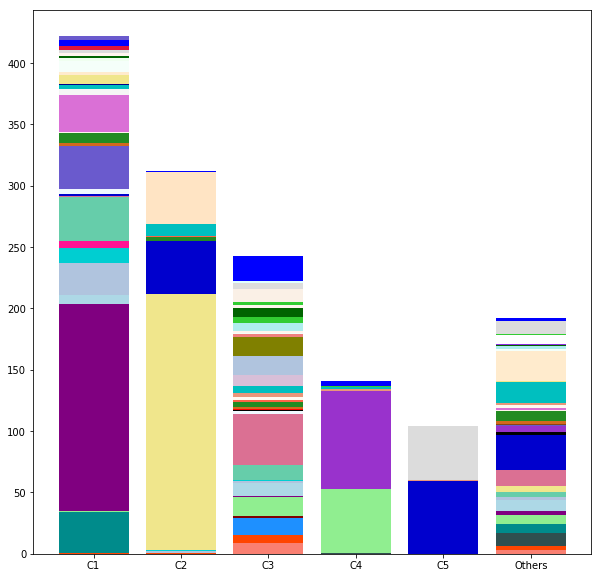

In [145]:
idx = np.arange(6)
plt.figure(figsize=(10,10))
p = []
for i in range(len(uniq_ind)):
    bottom = [0] * 6
    for j in range(i): bottom = [a+b for a, b in zip(bottom, np.array(lst2_sector[j]))]
    p.append(plt.bar(idx, lst2_sector[i], bottom=bottom, color=colors[np.random.randint(len(colors))]))
plt.xticks(idx, ['C1','C2','C3','C4','C5','Others'])
#plt.legend((p[i] for i in range(len(uniq_ind))), (i for i in uniq_ind));
#plt.savefig(ROOTPATH + '/IndStackedBarChart_01.pdf', bbox_inches='tight')


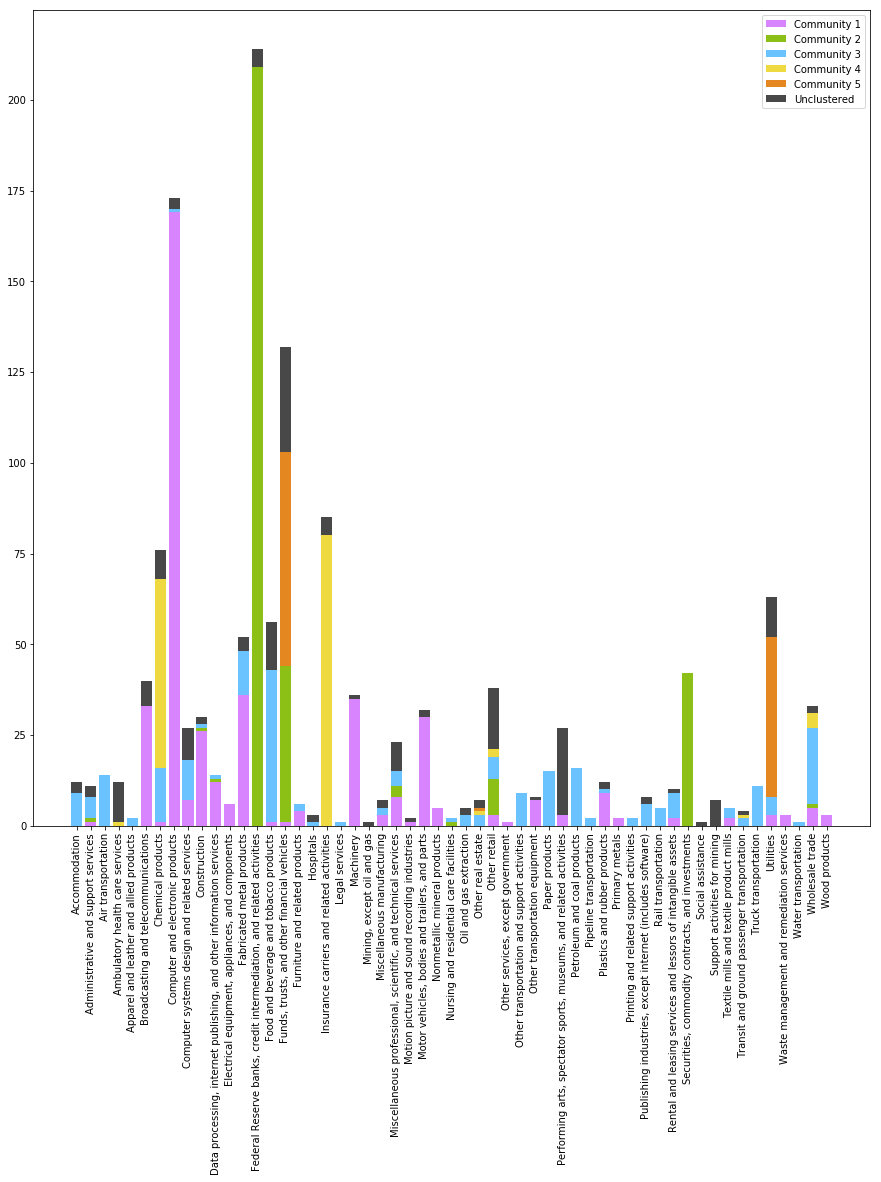

In [50]:
idx = np.arange(len(uniq_ind))
plt.figure(figsize=(15,15))
p1 = plt.bar(idx, lst_community_1, color=(0.85, 0.5176, 1))
p2 = plt.bar(idx, lst_community_2, bottom=lst_community_1, color=(0.553, 0.753, 0.0863))
p3 = plt.bar(idx, lst_community_3,
             bottom=np.array(lst_community_1)+np.array(lst_community_2), color=(0.4157, 0.7608, 1))
p4 = plt.bar(idx, lst_community_4,
             bottom=np.array(lst_community_1)+np.array(lst_community_2)+np.array(lst_community_3), color=[0.937255,0.851,0.25333])
p5 = plt.bar(idx, lst_community_5,
             bottom=np.array(lst_community_1)+np.array(lst_community_2)+np.array(lst_community_3)+np.array(lst_community_4), color=[0.898,0.5294,0.1294])
p6 = plt.bar(idx, lst_community_6,
             bottom=np.array(lst_community_1)+np.array(lst_community_2)+np.array(lst_community_3)+np.array(lst_community_4)+np.array(lst_community_5), color=[0.283,0.2823,0.282])
plt.xticks(idx, uniq_ind, rotation=90)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('Community 1', 'Community 2', 'Community 3', 'Community 4', 'Community 5', 'Unclustered'));
plt.savefig(ROOTPATH + '/IndStackedBarChart_01.pdf', bbox_inches='tight')

In [ ]:
idx = np.arange(len(uniq_ind))
plt.figure(figsize=(15,15))


In [60]:
yellow_1 = ['ARRY', 'PAHC', 'VVUS', 'BMY', 'CYTK', 'BEAT', 'USNA', 'MYGN', 'CRVL', 'OPK', 'JNJ', 'INT', 'IDXX', 'ABT', 'ZTS', 'NEOG', 'IPXL', 'LCI', 'AKRX', 'LLY', 'CBM', 'MYL', 'MRK', 'ABBV', 'PFE', 'ANIP', 'ALXN', 'SUPN', 'ACOR', 'GILD', 'LGND', 'BIIB', 'ACHN', 'UTHR', 'RGEN', 'TECH', 'PBH', 'AMGN', 'CORT', 'CELG', 'REGN', 'AGTC', 'PCRX', 'INSY', 'AMAG', 'XNCR', 'FPRX', 'GERN', 'BTX', 'PGNX', 'EBS', 'ENTA', 'BSTC', 'ZGNX', 'RTRX']
yellow_2 = ['EHTH', 'CVS', 'ABC', 'TIPT', 'CIA', 'IHC', 'NMIH', 'PMC', 'DGICA', 'UIHC', 'HCI', 'FNHC', 'BWINB', 'AFH', 'NSR', 'CI', 'HUM', 'GTS', 'MOH', 'CNC', 'WCG', 'STC', 'HALL', 'HRTG', 'AMSF', 'UVE', 'STFC', 'OB', 'ERIE', 'AIZ', 'SAFT', 'PRA', 'MCY', 'RLI', 'NGHC', 'ALL', 'MTG', 'MBI', 'RDN', 'PGR', 'THG', 'EIG', 'NWLI', 'ANTM', 'FNF', 'UAM', 'FAF', 'UNH', 'AET', 'MKL', 'ORI', 'UFCS', 'EMCI', 'IPCC', 'CNA', 'MKL', 'SIGI', 'KMPR', 'CINF', 'BRO', 'AFG', 'NAVG', 'AFL', 'UNM', 'LNC', 'VOYA', 'HIG', 'WRB', 'FFG', 'HMNY', 'L', 'CNO', 'TMK', 'MMC', 'PRI', 'AJG', 'AIG', 'ANAT', 'AEL', 'MET', 'RGA', 'PRU', 'PFG', 'HF', 'CAH', 'MCK']

In [61]:
pd.Series(getIndustryCodeByStockCode(yellow_1,'Title')).value_counts()

Chemical products                            52
Insurance carriers and related activities     1
Wholesale trade                               1
Ambulatory health care services               1
dtype: int64

In [149]:
getIndustryCodeByStockCode(['CAH'],'Title')

['Wholesale trade']

In [62]:
pd.Series(getIndustryCodeByStockCode(yellow_2,'Title')).value_counts()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


Insurance carriers and related activities      78
Wholesale trade                                 3
Other retail                                    2
Transit and ground passenger transportation     1
Other real estate                               1
dtype: int64

In [56]:
getIndustryCodeByStockCode(['MCK'],'Title')

['Wholesale trade']

### Visualization

In [ ]:
nx.draw_circular(G)

In [ ]:
plt.show()

In [93]:
pos = nx.spring_layout(G)

In [94]:
val_map = dict().fromkeys(uniq_asgn, 0)

NameError: name 'uniq_asgn' is not defined

In [ ]:
val_map

In [410]:
val_color = np.append(np.arange(0,1,1/(len(uniq_asgn)-1)), 1)

In [412]:
for i in range(len(uniq_asgn)): val_map[uniq_asgn[i]]=val_color[i]

In [363]:
red_edges = [('A', 'C'), ('E', 'C')]
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]
black_edges = [edge for edge in G.edges() if edge not in red_edges]

0

In [416]:
values = [val_map.get(asgn) for asgn in sri_overall_asgn]

In [89]:
edges = G.edges()

In [ ]:
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 100)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='r', arrows=True)
#nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
plt.show()

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1145e1598> (for post_execute):


ValueError: object too deep for desired array

## 6. Topological Properties of the Directed Weighted Network

### Centrality

In [820]:
df_strength = pd.DataFrame(list(G.degree(weight='corr')), columns=['ticker', 'strength'])
df_strength['industry_title'] = None
for i in range(len(df_strength)):
    df_strength.iloc[i, 2] = df_codes_and_title.loc[df_strength.iloc[i, 0], 'Title']
df_strength.sort_values(by='strength', ascending=False)

,ticker,strength,industry_title
131,AXE,367.635292,Wholesale trade
110,ARW,367.158779,Wholesale trade
795,MAN,345.831359,Administrative and support services
525,FMBI,338.960124,"Federal Reserve banks, credit intermediation, ..."
21,ACM,334.033942,"Miscellaneous professional, scientific, and te..."
550,FULT,332.222086,"Federal Reserve banks, credit intermediation, ..."
554,GBCI,330.990751,"Federal Reserve banks, credit intermediation, ..."
1264,TRMK,330.558343,"Federal Reserve banks, credit intermediation, ..."
227,CBU,328.449914,"Federal Reserve banks, credit intermediation, ..."
885,NBTB,328.448296,"Federal Reserve banks, credit intermediation, ..."


In [532]:
np.average(df_strength.strength)

75.20022667117517

### Log-log linear fitting for strength distribution

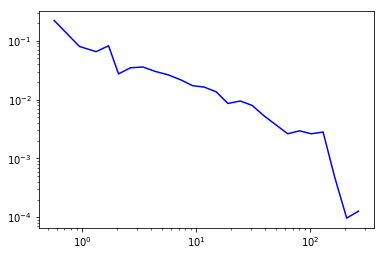

In [979]:
data = [d for n, d in G.out_degree(weight='corr') if d > 0]
powerlaw.plot_pdf(data, linear_bins = False, color = 'b');

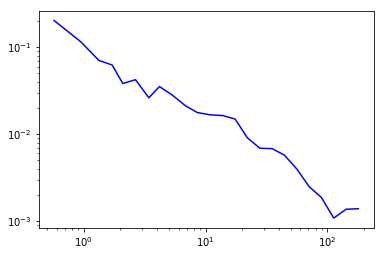

In [977]:
data = [d for n, d in G.in_degree(weight='corr') if d > 0]
powerlaw.plot_pdf(data, linear_bins = False, color = 'b');

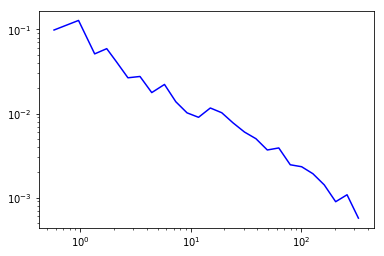

In [978]:
data = [d for n, d in G.degree(weight='corr') if d > 0]
powerlaw.plot_pdf(data, linear_bins = False, color = 'b');

### Modularity

In [815]:
cnt = 0
for i in range(G.number_of_nodes()):
    node_i = lst_tickers_stp[i]
    for j in range(i+1, G.number_of_nodes()):
        node_j = lst_tickers_stp[j]
        if G.has_edge(node_i, node_j) and G.has_edge(node_j, node_i):
            cnt+=1

In [816]:
G.number_of_edges()

102051

In [67]:
192910/413726

0.46627478089363494

In [1535]:
nx.write_gml(G, ROOTPATH + r'/test_com_over_best.gml')

In [818]:
cnt/G.number_of_edges()

0.33874239350912777

### Abnormal return regression with topological features as factors

In [995]:
df_stock_abr = pd.read_csv(FILE_STOCK_ABR).set_index('Date')

In [ ]:
df_stock_abr_coef = pd.DataFrame(index=lst_tickers_stp, columns=['beta_0','beta_1'])
X = sm.add_constant(sri_SP500_log_return)
for tckr in lst_tickers_stp:
    y = DICT_STP[tckr]['log_return']
    model = sm.OLS(y,X)
    results = model.fit()
    df_stock_abr_coef.loc[tckr, 'beta_0'] = results.params['const']
    df_stock_abr_coef.loc[tckr, 'beta_1'] = results.params['Close']

df_stock_abr = pd.DataFrame(index=sri_SP500_log_return.index, columns=lst_tickers_stp)
for tckr in lst_tickers_stp:
     df_stock_abr[tckr] = DICT_STP[tckr]['log_return'] - df_stock_abr_coef.loc[tckr, 'beta_0'] - df_stock_abr_coef.loc[tckr, 'beta_1'] * sri_SP500_log_return

In [ ]:
for tckr in lst_tickers_stp:
    y = df_stock_abr[tckr][1:]
    AR_lag = df_stock_abr['A'].shift()[1:]
    
    model = sm.OLS(y,X)
    results = model.fit()
    df_stock_abr_coef.loc[tckr, 'beta_0'] = results.params['const']
    df_stock_abr_coef.loc[tckr, 'beta_1'] = results.params['Close']

### 随机选择部分结点生成网络

In [ ]:
chosen_tickers = np.random.choice(lst_tickers_stp, 50, replace=False)

### The relationship between abnormal return and centrality

In [1047]:
df_stock_abr = pd.read_csv(FILE_STOCK_ABR).set_index('Date')

In [1140]:
df_abr_ctr = pd.DataFrame(index=lst_tickers_stp, columns=['sum_return', 'std_return', 'centrality'])

In [1141]:
centralities = nx.betweenness_centrality(G)

In [1157]:
sorted_centralities = sorted(centralities.items(), reverse=True, key=lambda kv: kv[1])

In [1174]:
for i in sorted_centralities: print(getIndustryCodeByStockCode([i[0]], code_type='Title')[0])

Other real estate
Plastics and rubber products
Rail transportation
Hospitals
Rental and leasing services and lessors of intangible assets
Wholesale trade
Hospitals
Miscellaneous professional, scientific, and technical services
Miscellaneous professional, scientific, and technical services
Wholesale trade
Other transportation and support activities
Miscellaneous professional, scientific, and technical services
Securities, commodity contracts, and investments
Administrative and support services
Securities, commodity contracts, and investments
Wholesale trade
Plastics and rubber products
Rail transportation
Administrative and support services
Miscellaneous professional, scientific, and technical services
Other real estate
Transit and ground passenger transportation
Construction
Wholesale trade
Wholesale trade
Insurance carriers and related activities
Insurance carriers and related activities
Electrical equipment, appliances, and components
Plastics and rubber products
Rental and leasing s

Fabricated metal products
Computer and electronic products
Wholesale trade
Computer and electronic products
Broadcasting and telecommunications
Support activities for mining
Nonmetallic mineral products
Support activities for mining
Printing and related support activities
Support activities for mining
Food and beverage and tobacco products
Other transportation equipment
Petroleum and coal products
Motor vehicles, bodies and trailers, and parts
Plastics and rubber products
Chemical products
Machinery
Motor vehicles, bodies and trailers, and parts
Federal Reserve banks, credit intermediation, and related activities
Truck transportation
Miscellaneous professional, scientific, and technical services
Federal Reserve banks, credit intermediation, and related activities
Performing arts, spectator sports, museums, and related activities
Wholesale trade
Motor vehicles, bodies and trailers, and parts
Computer and electronic products
Rental and leasing services and lessors of intangible assets
Fo

Federal Reserve banks, credit intermediation, and related activities
Federal Reserve banks, credit intermediation, and related activities
Computer and electronic products
Federal Reserve banks, credit intermediation, and related activities
Fabricated metal products
Federal Reserve banks, credit intermediation, and related activities
Computer and electronic products
Federal Reserve banks, credit intermediation, and related activities
Federal Reserve banks, credit intermediation, and related activities
Federal Reserve banks, credit intermediation, and related activities
Accommodation
Federal Reserve banks, credit intermediation, and related activities
Federal Reserve banks, credit intermediation, and related activities
Computer and electronic products
Insurance carriers and related activities
Other transportation equipment
Computer and electronic products
Federal Reserve banks, credit intermediation, and related activities
Federal Reserve banks, credit intermediation, and related activit

Fabricated metal products
Insurance carriers and related activities
Chemical products
Funds, trusts, and other financial vehicles
Computer and electronic products
Federal Reserve banks, credit intermediation, and related activities
Computer and electronic products
Ambulatory health care services
Federal Reserve banks, credit intermediation, and related activities
Other retail
Computer systems design and related services
Funds, trusts, and other financial vehicles
Insurance carriers and related activities
Chemical products
Insurance carriers and related activities
Computer and electronic products
Federal Reserve banks, credit intermediation, and related activities
Air transportation
Chemical products
Federal Reserve banks, credit intermediation, and related activities
Food and beverage and tobacco products
Computer and electronic products
Federal Reserve banks, credit intermediation, and related activities
Computer and electronic products
Air transportation
Computer and electronic produ

Computer systems design and related services
Fabricated metal products
Securities, commodity contracts, and investments
Computer and electronic products
Wholesale trade
Insurance carriers and related activities
Computer and electronic products
Computer and electronic products
Motor vehicles, bodies and trailers, and parts
Truck transportation
Federal Reserve banks, credit intermediation, and related activities
Federal Reserve banks, credit intermediation, and related activities
Funds, trusts, and other financial vehicles
Insurance carriers and related activities
Computer and electronic products
Construction
Utilities
Insurance carriers and related activities
Federal Reserve banks, credit intermediation, and related activities
Other retail
Federal Reserve banks, credit intermediation, and related activities
Broadcasting and telecommunications
Other transportation equipment
Air transportation
Other transportation and support activities
Fabricated metal products
Funds, trusts, and other f

Funds, trusts, and other financial vehicles
Food and beverage and tobacco products
Broadcasting and telecommunications
Food and beverage and tobacco products
Funds, trusts, and other financial vehicles
Utilities
Food and beverage and tobacco products
Federal Reserve banks, credit intermediation, and related activities
Other services, except government
Broadcasting and telecommunications
Chemical products
Utilities
Utilities
Funds, trusts, and other financial vehicles
Computer and electronic products
Motor vehicles, bodies and trailers, and parts
Other retail
Funds, trusts, and other financial vehicles
Utilities
Motor vehicles, bodies and trailers, and parts
Utilities
Other retail
Computer and electronic products
Computer and electronic products
Motor vehicles, bodies and trailers, and parts
Funds, trusts, and other financial vehicles
Federal Reserve banks, credit intermediation, and related activities
Computer systems design and related services
Rental and leasing services and lessors 

In [1183]:
sri_SP500 = sri_SP500_close[1:]

In [1184]:
price_syn = pd.Series(index=sri_SP500.index, data=0.0)

In [1187]:
price_syn += DICT_STP['A'].close

In [1191]:
sum_cent

0.3649549157411503

In [1217]:
sorted_centralities[-285:]

[('FLIR', 2.7340781558742633e-08),
 ('MSL', 2.7223853714881834e-08),
 ('CHTR', 2.6585377967253585e-08),
 ('BELFB', 2.2941633888609477e-08),
 ('ROG', 2.2806546507548628e-08),
 ('IMMR', 1.927560324198559e-08),
 ('KRA', 1.510264299877113e-08),
 ('VRTU', 1.50244098197134e-08),
 ('MLAB', 7.223003173325322e-09),
 ('SAMG', 2.8642943618359036e-09),
 ('AAT', 0.0),
 ('ABAX', 0.0),
 ('ABCO', 0.0),
 ('ACC', 0.0),
 ('ACLS', 0.0),
 ('ADC', 0.0),
 ('ADUS', 0.0),
 ('AEE', 0.0),
 ('AEO', 0.0),
 ('AEP', 0.0),
 ('AEPI', 0.0),
 ('AFH', 0.0),
 ('AFSI', 0.0),
 ('AGNC', 0.0),
 ('AHP', 0.0),
 ('ALX', 0.0),
 ('ANH', 0.0),
 ('AOSL', 0.0),
 ('ARRY', 0.0),
 ('ARTNA', 0.0),
 ('ATNI', 0.0),
 ('ATRI', 0.0),
 ('AVA', 0.0),
 ('AVB', 0.0),
 ('AWK', 0.0),
 ('AWR', 0.0),
 ('BANC', 0.0),
 ('BBGI', 0.0),
 ('BBRG', 0.0),
 ('BBW', 0.0),
 ('BCEI', 0.0),
 ('BEAT', 0.0),
 ('BMI', 0.0),
 ('BMY', 0.0),
 ('BREW', 0.0),
 ('CAC', 0.0),
 ('CAMP', 0.0),
 ('CBK', 0.0),
 ('CCI', 0.0),
 ('CDR', 0.0),
 ('CFFI', 0.0),
 ('CFNB', 0.0),
 ('CH

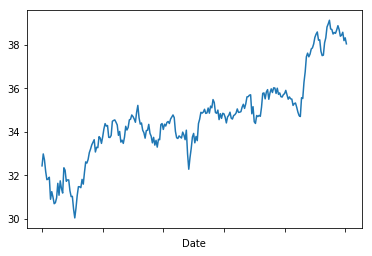

In [1224]:
N = 325
price_syn = pd.Series(index=sri_SP500.index, data=0.0)
sum_cent = 0.0
for p in sorted_centralities[-N:]: sum_cent += p[1]
for p in sorted_centralities[-N:]: price_syn += DICT_STP[p[0]].close * p[1] / sum_cent
price_syn.plot()

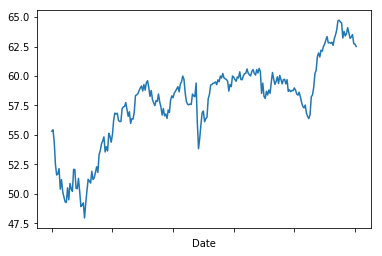

In [1225]:
N = 295
price_syn = pd.Series(index=sri_SP500.index, data=0.0)
sum_cent = 0.0
for p in sorted_centralities[:51]: sum_cent += p[1]
for p in sorted_centralities[:51]: price_syn += DICT_STP[p[0]].close * p[1] / sum_cent
price_syn.plot()

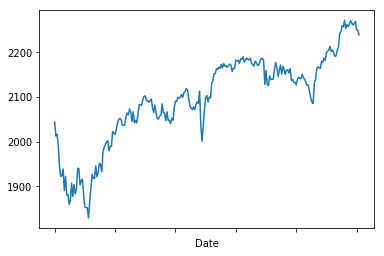

In [1200]:
sri_SP500_close.plot()

In [1142]:
for i in lst_tickers_stp: df_abr_ctr.loc[i] = (sum(df_stock_normal_return[i]), np.std(df_stock_normal_return[i]), centralities[i])

In [1143]:
df_abr_ctr

,sum_return,std_return,centrality
A,0.0858946,0.0148152,0.000663745
AAL,0.0975616,0.0231343,3.53711e-05
AAN,0.356809,0.0240018,0.000923301
AAOI,0.311863,0.0431361,2.60014e-06
AAON,0.353008,0.0185523,0.000636769
AAPL,0.0956038,0.0147138,1.01974e-05
AAT,0.116304,0.0122002,0
AAWW,0.232294,0.0280934,9.62488e-06
ABAX,-0.0536782,0.022284,0
ABBV,0.0554877,0.0173599,6.33891e-05


<Figure size 432x288 with 0 Axes>

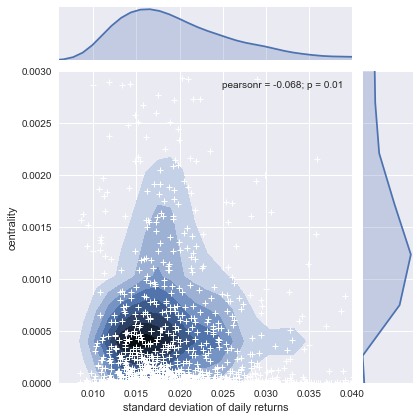

In [1480]:
plt.figure()
g = sns.jointplot(x='std_return', y='centrality', data=df_abr_ctr, kind="kde", xlim=(0.006, 0.04), ylim=(0, 0.003))
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_marg_x()
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels('standard deviation of daily returns', 'centrality');
#g.savefig(ROOTPATH + '/Msc/Dissertation/Figures/std_return_centrality.pdf', bbox_inches='tight')

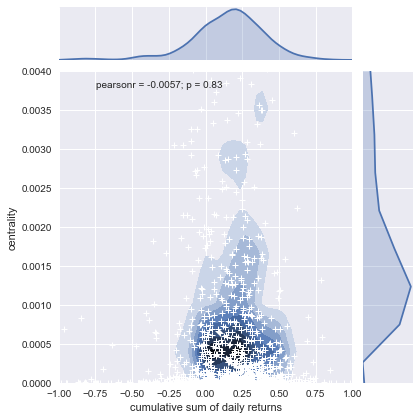

In [1488]:
g = sns.jointplot(x='sum_return', y='centrality', data=df_abr_ctr, kind="kde", xlim=(-1, 1), ylim=(0, 0.004))
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels('cumulative sum of daily returns', 'centrality');
g.savefig(ROOTPATH + '/Msc/Dissertation/Figures/sum_return_centrality.pdf', bbox_inches='tight')

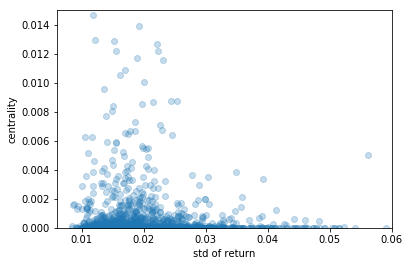

In [1148]:
x = df_abr_ctr['std_return']
y = df_abr_ctr['centrality']
plt.scatter(x, y, alpha=0.25)

#plt.axis([-1, 1, 0, 0.02])
plt.axis([0.006, 0.06, 0, 0.015])
plt.ylabel('centrality')
plt.xlabel('std of return')
plt.show()

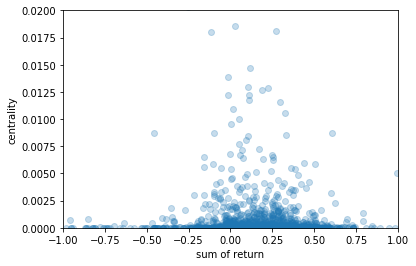

In [1150]:
x = df_abr_ctr['sum_return']
y = df_abr_ctr['centrality']
plt.scatter(x, y, alpha=0.25)

plt.axis([-1, 1, 0, 0.02])
plt.ylabel('centrality')
plt.xlabel('sum of return')
plt.show()

### New indiced

In [1287]:
assort = nx.algorithms.degree_assortativity_coefficient(G_ws_mat)
assort

-0.0021803687187969306

In [1283]:
assort = nx.algorithms.degree_assortativity_coefficient(G_int, weight='corr')
assort

0.12444731038165072

In [1277]:
np.round(G['A']['AAPL']['corr'] * 100 % 100)

40.0

In [1281]:
G_int = G.copy()
for n, nbrs in G.adj.items():
    for nbr, eattr in nbrs.items():
        G_int[n][nbr]['corr'] = int(np.round(eattr['corr'] * 100 % 100))

In [1282]:
G_int['A']['AAPL']

{'corr': 40}

In [17]:
getIndustryCodeByStockCode(['PDM'],'Title')

['Other real estate']